# Bayesian regression using PyMC

Please report any bugs to Joris De Ridder.

## Imports

In [1]:
import sys
print("Python version: ", sys.version)

Python version:  3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:25:12) [Clang 14.0.6 ]


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
print("NumPy version: ", np.__version__)
print("SciPy version: ", sp.__version__)
print("Pandas version: ", pd.__version__)

NumPy version:  1.24.3
SciPy version:  1.10.1
Pandas version:  1.5.3


In [3]:
from scipy.special import expit                    # logistic sigmoid function: expit(x) = 1/(1+exp(-x))

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
print("Statsmodels version: ", sm.__version__)

Statsmodels version:  0.13.5


In [5]:
import pymc as pm
import pytensor
import pytensor.tensor as pt 
print("PyMC version: ", pm.__version__)
print("PyTensor version: ", pytensor.__version__)

PyMC version:  5.3.0
PyTensor version:  2.11.1


In [6]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
print("Matplotlib version: ", matplotlib.__version__)

Matplotlib version:  3.7.1


In [7]:
import plotly
print("Plotly version: ", plotly.__version__)

Plotly version:  5.14.1


In [8]:
import arviz as az
print("Arviz version: ", az.__version__)

Arviz version:  0.15.1


In [9]:
import corner
print("Corner version: ", corner.__version__)

Corner version:  2.2.2


In [10]:
import lmfit
import sympy
import sklearn
print("lmfit version: ", lmfit.__version__)
print("sympy version: ", sympy.__version__)
print("sklearn version: ", sklearn.__version__)

lmfit version:  1.2.1
sympy version:  1.11.1
sklearn version:  1.2.2


## Matplotlib font sizes

In [11]:
plt.rc('font',   size=15)          # controls default text sizes
plt.rc('axes',   titlesize=15)     # fontsize of the axes title
plt.rc('axes',   labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=15)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=15)     # fontsize of the tick labels
plt.rc('legend', fontsize=15)      # legend fontsize
plt.rc('figure', titlesize=15)     # fontsize of the figure title

## Links to documentation on the web

* [PyMC documentation](https://docs.pymc.io)
* [PyMC examples](https://www.pymc.io/projects/examples/en/latest/gallery.html)

## Contents

* [Basic linear regression [PYMC]](#Basic-linear-regression-with-PyMC)
* [Linear regression using a design matrix [PyMC]](#Linear-regression-using-a-design-matrix-with-PyMC)
* [Robust regression using a Student's T-distribution [PyMC]](#Robust-regression-using-a-StudentT-likelihood-with-PyMC)
* [Robust regression using the Hogg et al. approach [PyMC]](#Robust-regression-using-the-Hogg-approach-with-PyMC)
* [Piecewise linear regression [PyMC]](#Piecewise-linear-regression-with-PyMC)
* [Uncertainties in y and x [PyMC]](#Uncertainties-in-y-and-x-with-PyMC)
* [Fitting a distribution to a dataset [PyMC]](#Modeling-a-distribution-for-a-dataset-with-PyMC)
* [Modeling a fraction [PyMC]](#Modeling_a_fraction_with_PyMC)
* [Binomial logistic regression [PyMC]](#Fitting-a-logistic-model-with-PyMC)
* [Multinomial logistic regression [PyMC]](#A-multinomial-logistic-model-with-PyMC)
* [Modeling counts with Poisson [PyMC]](#Modeling-counts-with-Poisson-with-PyMC)
* [Modeling counts with Negative Binomial [PyMC]](#Modeling-counts-with-Negative-Binomial-with-PyMC)
* [Zero-truncated Poisson model [PyMC]](#A-zero-truncated-Poisson-model-with-PyMC)


## Basic linear regression with PyMC

#### A synthetic dataset:

In [11]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = 2
sigma = 0.3

x = np.linspace(0, 1, N)
y = theta0 + theta1 * x + rng.normal(0.0, sigma, N)

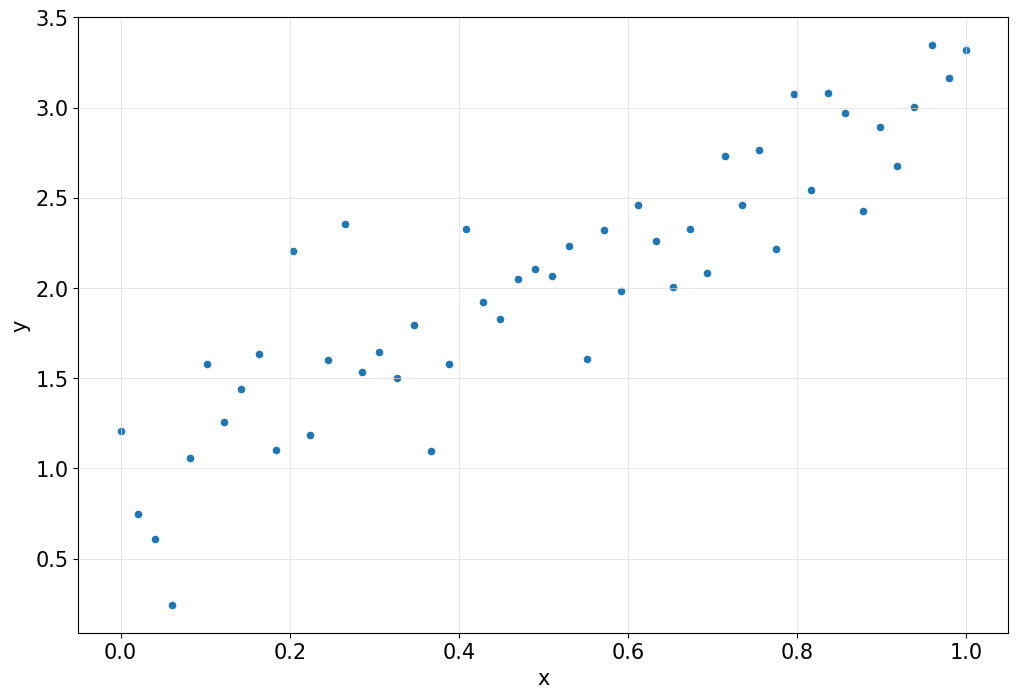

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The Bayesian model

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$


See the [PyMC documentation](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.HalfCauchy) on the definition of the HalfCauchy distribution.

In [13]:
with pm.Model() as myModel:
    
    xobs = pm.MutableData("xobs", x)
    yobs = pm.MutableData("yobs", y)
    
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


#### Summary of the trace

In [14]:
az.summary(trace, var_names=['intercept', 'slope', 'sigma'], hdi_prob=0.95, round_to=5)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept  0.95422  0.09512   0.76092    1.13672    0.00139  0.00098   
slope      2.15518  0.16395   1.83635    2.47536    0.00241  0.00171   
sigma      0.33978  0.03644   0.27297    0.41277    0.00048  0.00034   

             ess_bulk    ess_tail    r_hat  
intercept  4730.68696  5402.35564  1.00039  
slope      4682.63545  5530.63140  1.00074  
sigma      5734.75812  5000.85588  1.00100

The mean posterior values of the fit parameters can be obtained as follows:

In [15]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

#### Verify the behavior of the chains

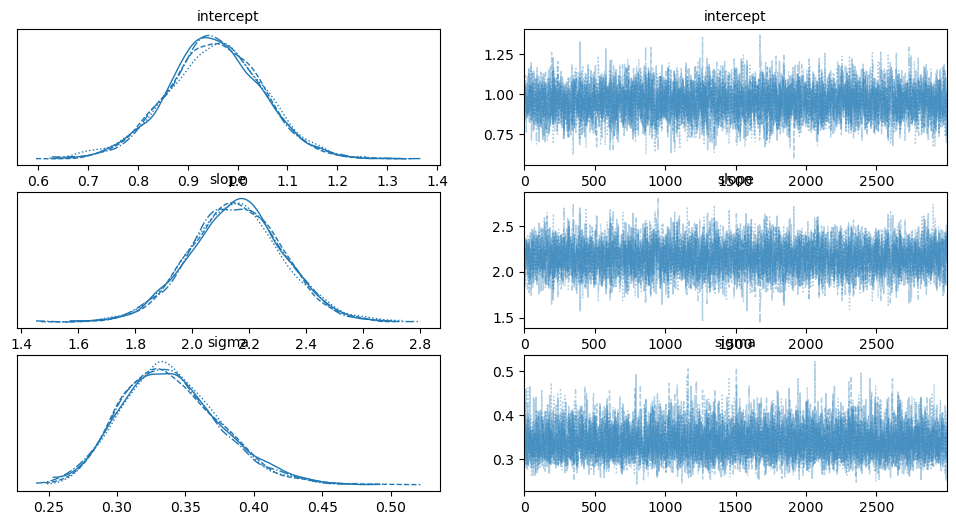

In [16]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

Auto-correlation functions:

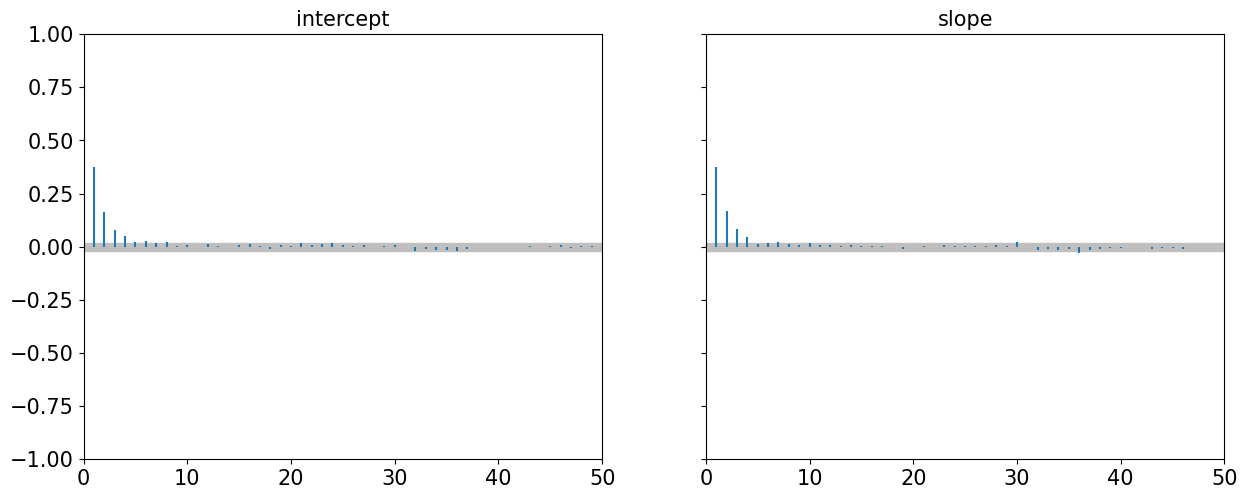

In [17]:
fig = az.plot_autocorr(trace, var_names=("intercept", "slope"), max_lag=50, combined=True)

#### One and two-dimensional projections of the posterior samples

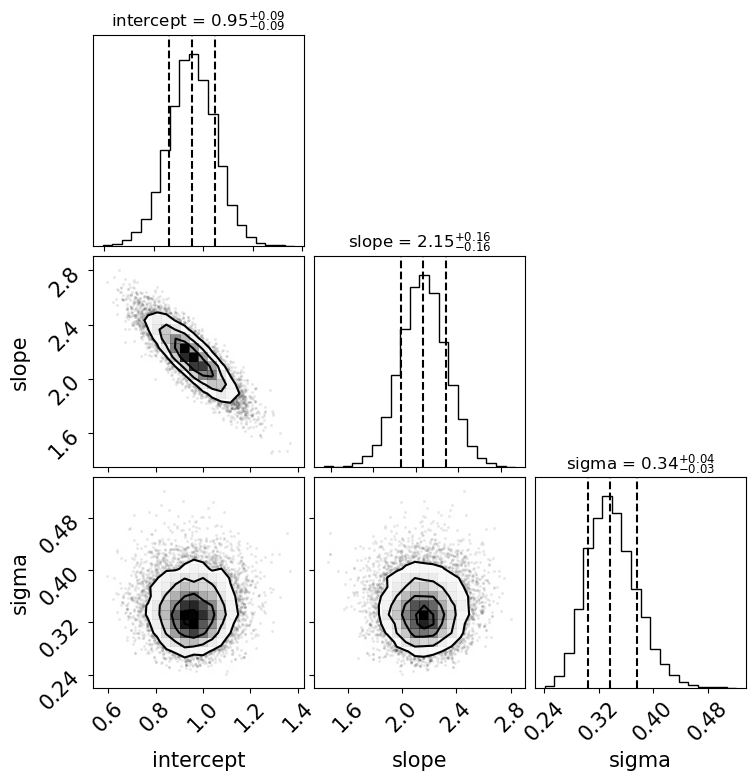

In [18]:
fig, ax = plt.subplots(3,3, figsize=(8,8))                                       # 3 because we're showing 3 params
fig = corner.corner(trace, fig=fig, var_names=['intercept', 'slope', 'sigma'],
                           quantiles=[0.16, 0.5, 0.84],
                           show_titles=True, 
                           title_kwargs={"fontsize": 12})

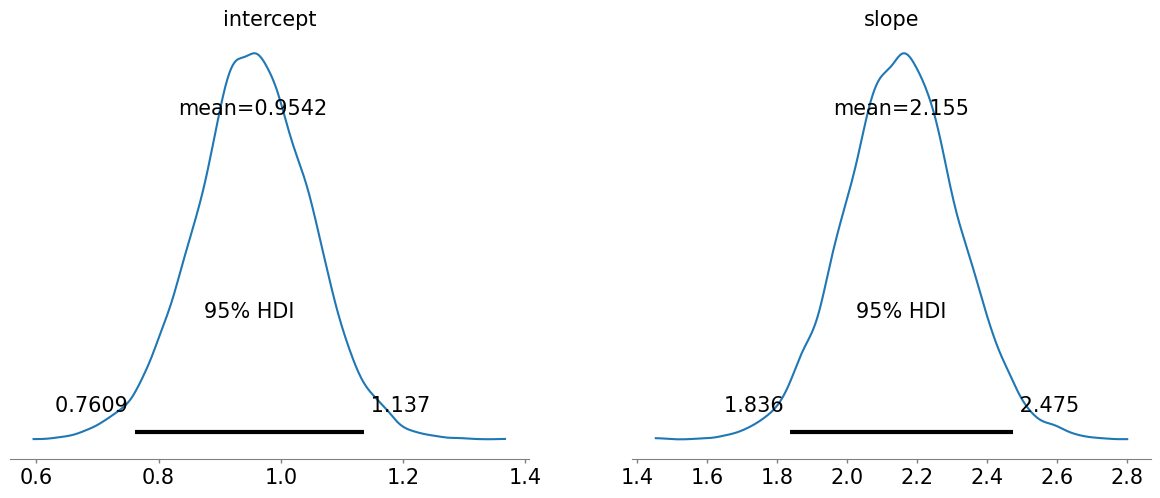

In [19]:
myPlot = az.plot_posterior(trace, var_names=['intercept', 'slope'], point_estimate='mean', hdi_prob=0.95, textsize=15, round_to=4)

Arviz allows to make a 2D contour plot of posterior samples: 

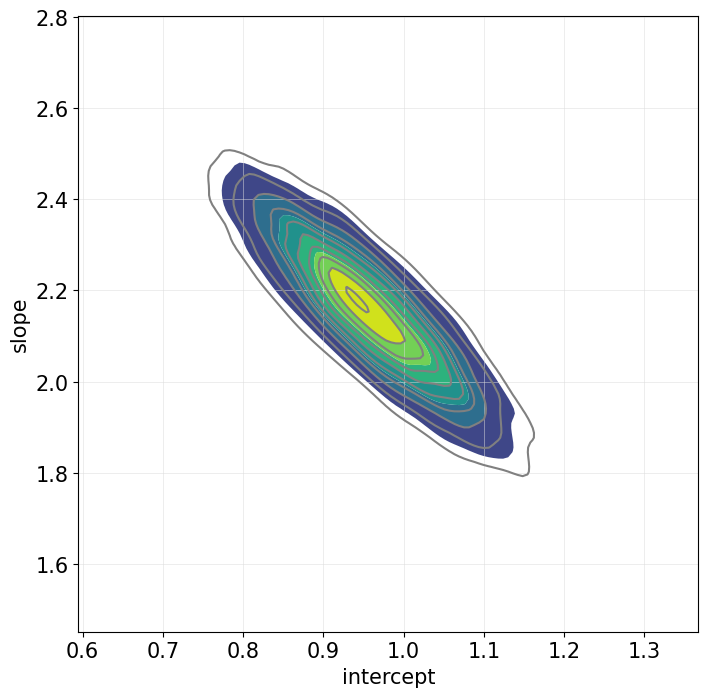

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
kde_kwargs = {'contour_kwargs': {'levels': 10}}
az.plot_pair(trace, ax=ax, var_names=['intercept', 'slope'], kind='kde', kde_kwargs=kde_kwargs);
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5, alpha=0.7)

#### Plotting the posterior model and the data

I first stack all the samples of all chains in one large stack.

In [21]:
stacked = trace.posterior.stack(draws=("chain", "draw"))
slope = stacked.slope.values
intercept = stacked.intercept.values

In [22]:
MAP = pm.find_MAP(model=myModel)
MAPintercept = MAP['intercept']
MAPslope = MAP['slope']
print("MAP value intercept: ", MAPintercept)
print("MAP value slope: ", MAPslope)


MAP value intercept:  0.9440441982003612
MAP value slope:  2.1767289140467674


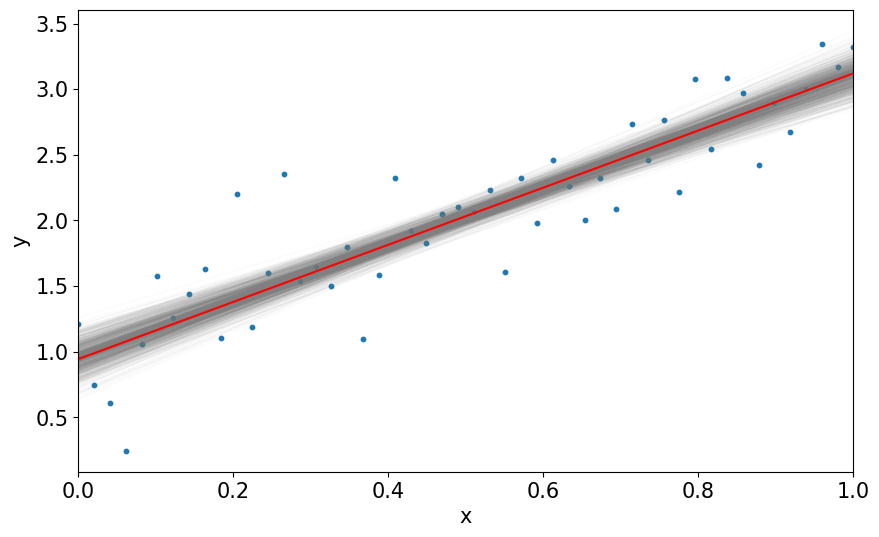

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 
ax.scatter(x,y, s=10)

M = len(slope)//1000
for n in range(0, len(slope), M):
    ax.plot(x, intercept[n] + slope[n]*x, c="gray", linewidth=1, alpha=0.03)

#ax.plot(x, meanIntercept + meanSlope * x, c="red", linewidth=1.5)
ax.plot(x, MAPintercept + MAPslope * x, c="red", linewidth=1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
plt.show()

#### Posterior predictive distribution

We aim to compute the posterior predictive distribution for a set of new x-values:

In [24]:
Nnew = 30
xnew = np.linspace(0, 1, Nnew)                        # Our set of new x-values 
with myModel:                                         # Use the same model as before 
   pm.set_data(
   {
      "xobs": xnew,                                   # Reset the x-values
      "yobs": np.zeros_like(xnew)                     # Not needed, but must be same size as xobs
   })

   postPred = pm.sample_posterior_predictive(trace.posterior, return_inferencedata=True)

Sampling: [y]


As usual, the Bayesian result is not a point estimate, but a distribution. For example the ynew distribution for xnew[0] and xnew[10] is:

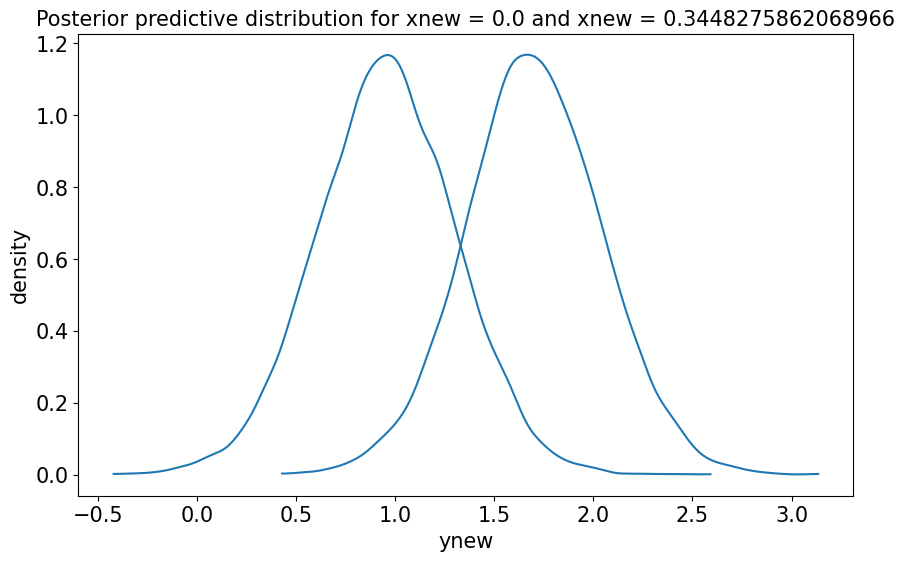

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
az.plot_kde(np.array(postPred.posterior_predictive['y'][:,:,0]).flatten(), ax=ax)
az.plot_kde(np.array(postPred.posterior_predictive['y'][:,:,10]).flatten(), ax=ax)
ax.set_xlabel("ynew")
ax.set_ylabel("density")
ax.set_title(f"Posterior predictive distribution for xnew = {xnew[0]} and xnew = {xnew[10]}")
plt.show()

Plot the 95% high-density probability.

In [26]:
meanPostPred = postPred.posterior_predictive['y'].mean(axis=(0,1))                        # Average over chains and samples

(0.0, 1.0)

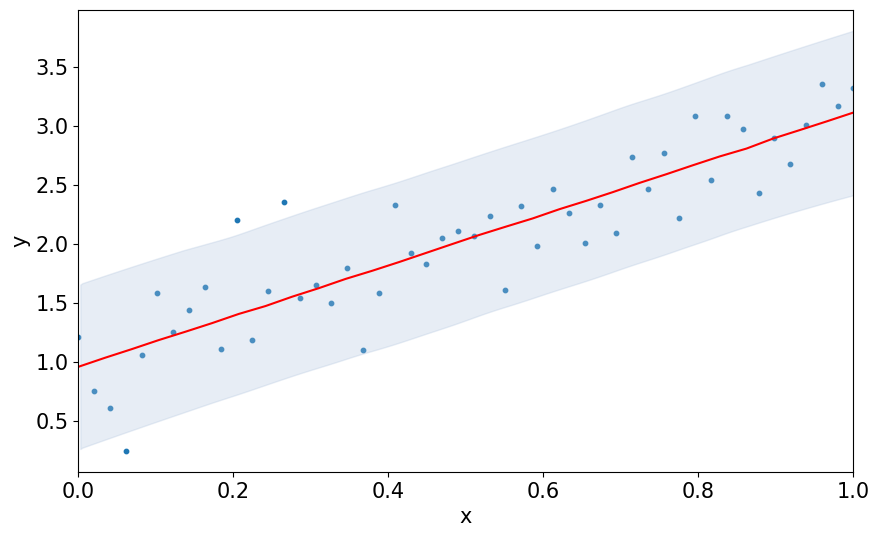

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y, s=10)
ax.plot(xnew, meanPostPred, c="red", linewidth=1.5)
az.plot_hdi(xnew, postPred.posterior_predictive['y'], hdi_prob=0.95, color="lightsteelblue", fill_kwargs={'alpha': 0.3}, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)

How does this compare with a 95% prediction interval obtained using least-squares?

In [28]:
df = pd.DataFrame({'y' : y, 'x': x})
N = len(y)
K = 2
olsFit = sm.OLS.from_formula(formula='y ~ x', data=df).fit()
s2 = np.sum(olsFit.resid**2) / (N-K)                               # Estimated variance of the (homescedastic) noise
covMatrix = olsFit.cov_params()                                    # Covariance matrix of the fit parameters
designX = sm.add_constant(np.column_stack([xnew]))                 # Design matrix
ynew = designX @ olsFit.params                                     # Estimated y-values given the xnew values.

sigma_y = np.zeros_like(xnew)
for n in range(len(xnew)):
    xvec = [1, xnew[n]]
    sigma_y[n] = np.sqrt(xvec @ covMatrix @ xvec + s2)             # Uncertainty on the predicted y-value
   
Tdistrib = sp.stats.t(N-K)                                         # Student's T-distribution
tMultiplier = Tdistrib.ppf(1-0.05/2)                               # 95% prediction interval

lowerPI = ynew - tMultiplier * sigma_y                             # PI stands for Prediction Interval
upperPI = ynew + tMultiplier * sigma_y

Text(0, 0.5, 'y')

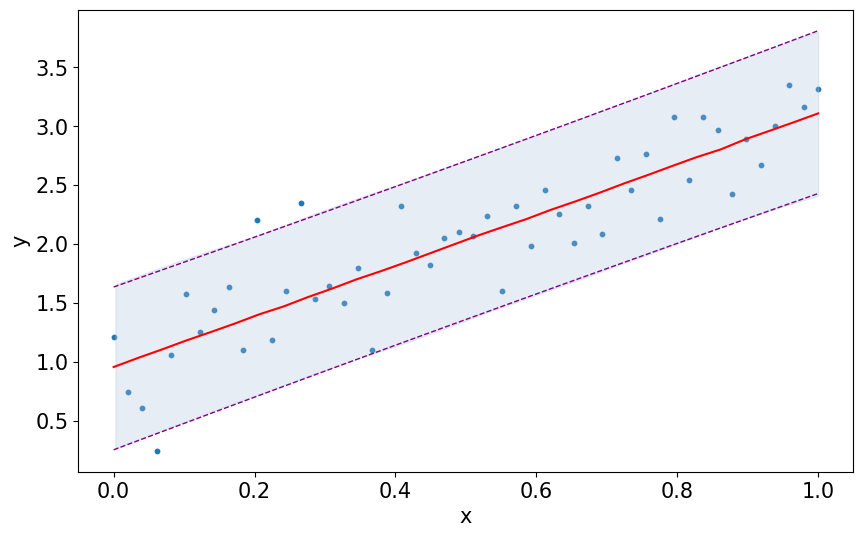

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y, s=10)
ax.plot(xnew, meanPostPred, c="red", linewidth=1.5)
az.plot_hdi(xnew, postPred.posterior_predictive['y'], hdi_prob=0.95, color="lightsteelblue", fill_kwargs={'alpha': 0.3}, ax=ax)   # The Bayesian version
ax.plot(xnew, lowerPI, c="purple", linewidth=1, linestyle='--')                                                                   # The Frequentist versoin
ax.plot(xnew, upperPI, c="purple", linewidth=1, linestyle='--')
ax.set_xlabel("x")
ax.set_ylabel("y")

Back to [contents](#Contents).

---

## Linear regression using a design matrix with PyMC

A synthetic dataset using a simply polynomial model:

In [30]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = -0.5
theta2 = 0.05
theta3 = 0.005
sigma = 0.3

x = np.sort(rng.uniform(0,10,N))
y = theta0 + theta1 * x + theta2 * x**2 + theta3 * x**3 + rng.normal(0.0, sigma, N)

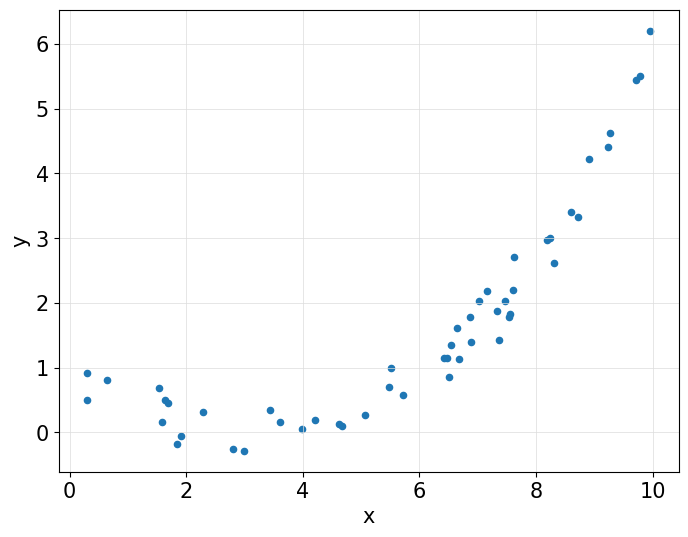

In [31]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The PyMC model using the matrix notation for our linear model with the design matrix $X$:

$X_{n,m} = x_n^m$

$\mu = X\cdot\theta$

$\theta_i = {\rm Normal}(0, 2)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$


The following code can be pretty slow.

In [32]:
with pm.Model() as myModel:
    
    xobs = pm.MutableData("xobs", x)
    yobs = pm.MutableData("yobs", y)
    
    sigma = pm.HalfCauchy("sigma", beta=3)
    theta = pm.Normal('theta', mu=0.0, sigma=2.0, size=4)                        # 3rd order polynomial implies 4 coefficients 
    X_ = [xobs**k for k in range(4)]
    X = pt.stack(X_, axis=1)

    likelihood = pm.Normal("y", mu=pt.dot(X, theta), sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 77 seconds.


Always check the trace(s):

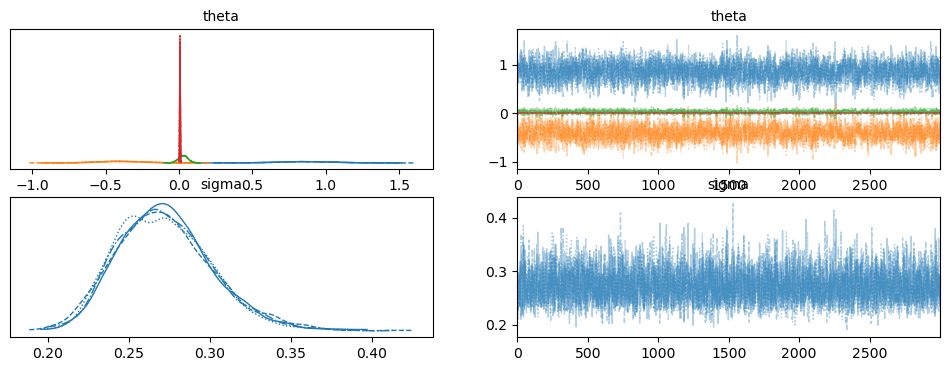

In [33]:
ax = az.plot_trace(trace)

From the summary it becomes obvious that not all coefficients are significant:

In [34]:
az.summary(trace, hdi_prob=0.95, round_to=5)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
theta[0]  0.86139  0.18747   0.49003    1.22974    0.00395  0.00279   
theta[1] -0.40555  0.15048  -0.68875   -0.09672    0.00354  0.00250   
theta[2]  0.02846  0.03231  -0.03561    0.09120    0.00076  0.00054   
theta[3]  0.00633  0.00201   0.00242    0.01034    0.00005  0.00003   
sigma     0.27240  0.02944   0.21856    0.33071    0.00043  0.00031   

            ess_bulk    ess_tail    r_hat  
theta[0]  2253.66238  3513.70153  1.00268  
theta[1]  1812.02454  3142.03714  1.00262  
theta[2]  1820.96254  3161.83742  1.00221  
theta[3]  1912.71674  3343.85549  1.00186  
sigma     4677.61789  4937.94311  1.00153

The mean of 1 coefficient can be extracted with, for example:

In [35]:
pm.summary(trace)['mean']['theta[0]']

0.861

As usual for polynomial regression, the coefficients are highly correlated.

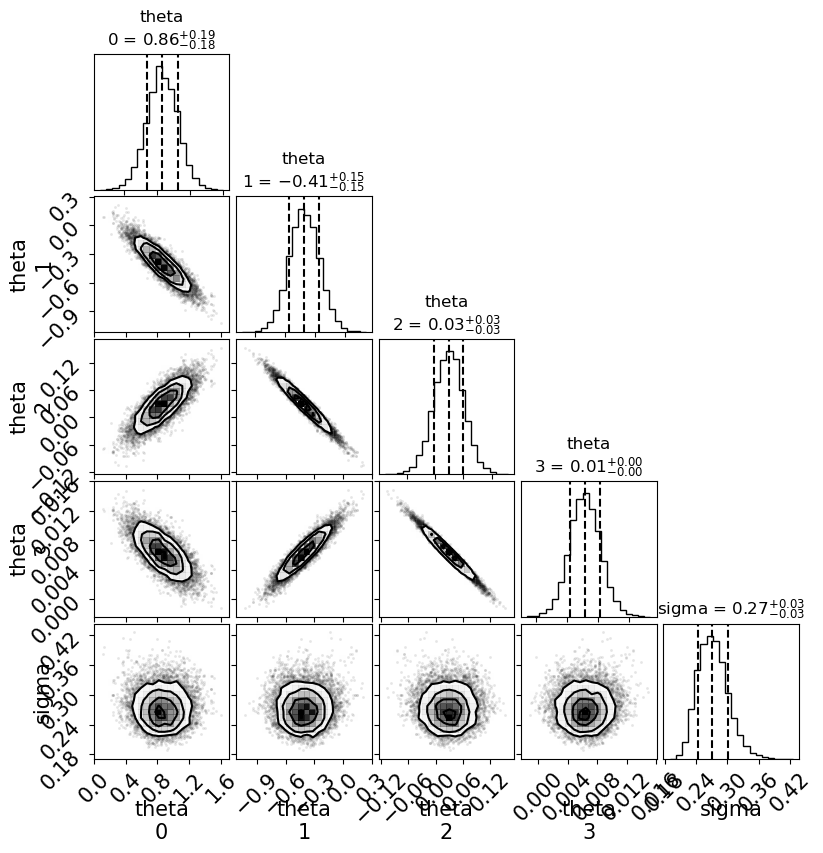

In [36]:
fig, ax = plt.subplots(5,5, figsize=(8,8))                                       # 3 because we're showing 3 params
fig = corner.corner(trace, fig=fig, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

Back to [contents](#Contents).

---

## Robust regression using a StudentT likelihood with PyMC

Create a synthetic dataset with outliers:

In [11]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers
data = pd.DataFrame({'y': y, 'x': x})

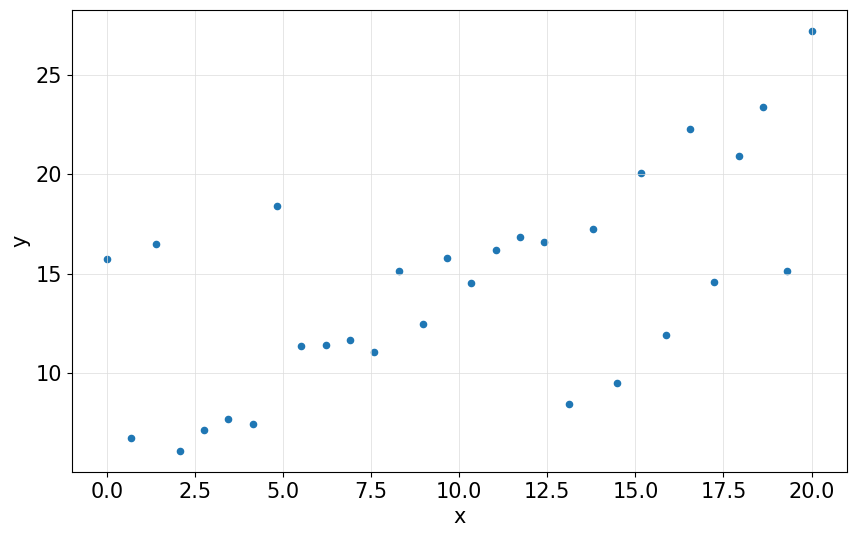

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The non-robust Bayesian model

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [13]:
with pm.Model() as myModel:
    
    xobs      = pm.Data("xobs", x)
    yobs      = pm.Data("yobs", y)
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


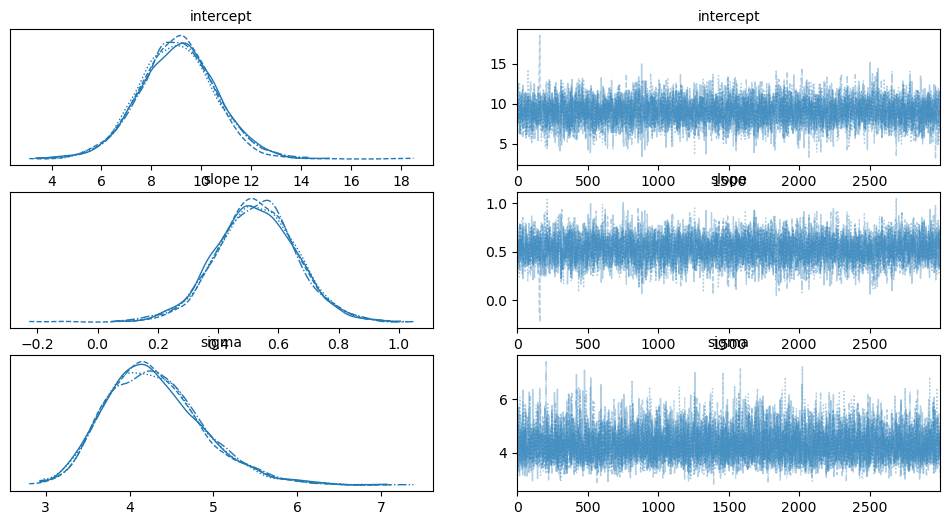

In [14]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

Note the way too high value of $\sigma$.

In [15]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

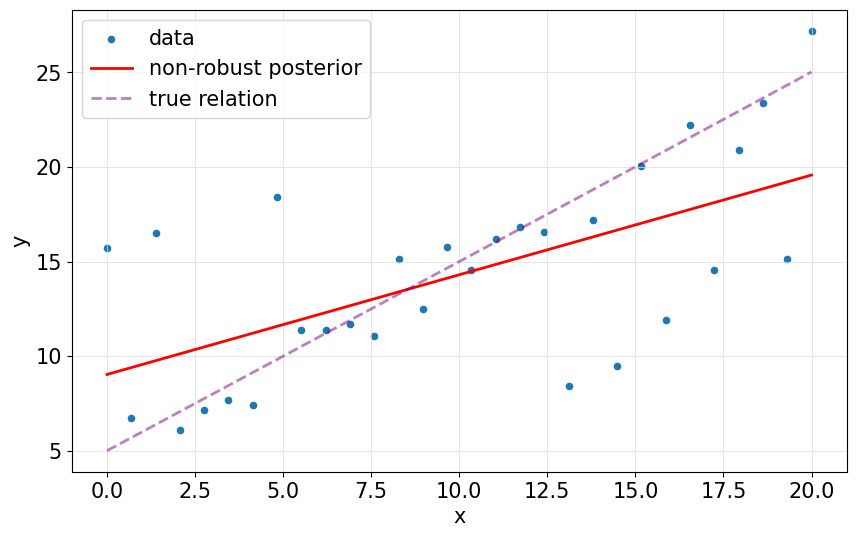

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="non-robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### A more robust Bayesian model

We use the Student's T-distribution instead of a Gaussian distribution for the likelihood:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 20)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm T}(\mu, \sigma, \nu=1)$

Note that the T-distribution with $\nu=1$ is the Cauchy distribution which has very broad tails.

In [17]:
with pm.Model() as myModel:
    
    xobs      = pm.Data("xobs", x)
    yobs      = pm.Data("yobs", y)
    sigma     = pm.HalfCauchy("sigma", beta=3)
    intercept = pm.Normal("intercept", 0, sigma=20)
    angle     = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope     = pm.Deterministic('slope', np.tan(angle))
    
    likelihood = pm.StudentT('y', nu=1, mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


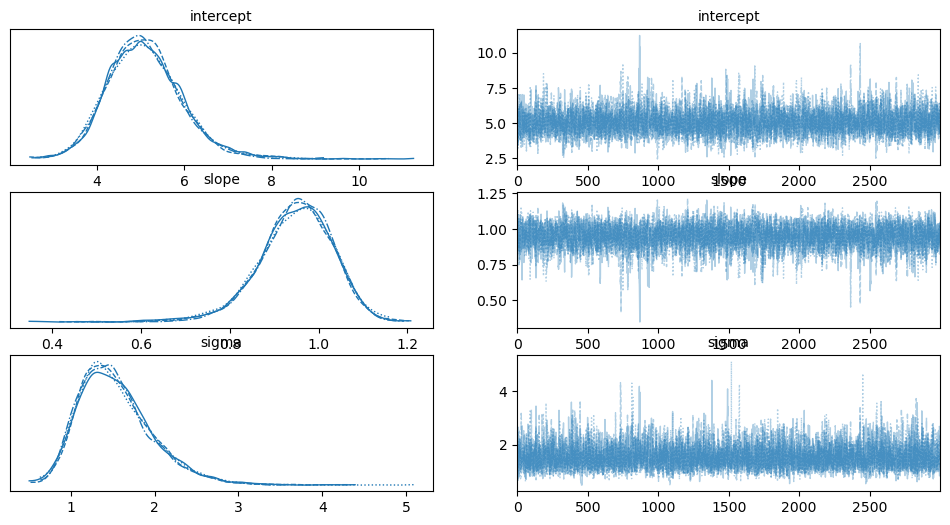

In [18]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'sigma'])

In [19]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope', 'sigma'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

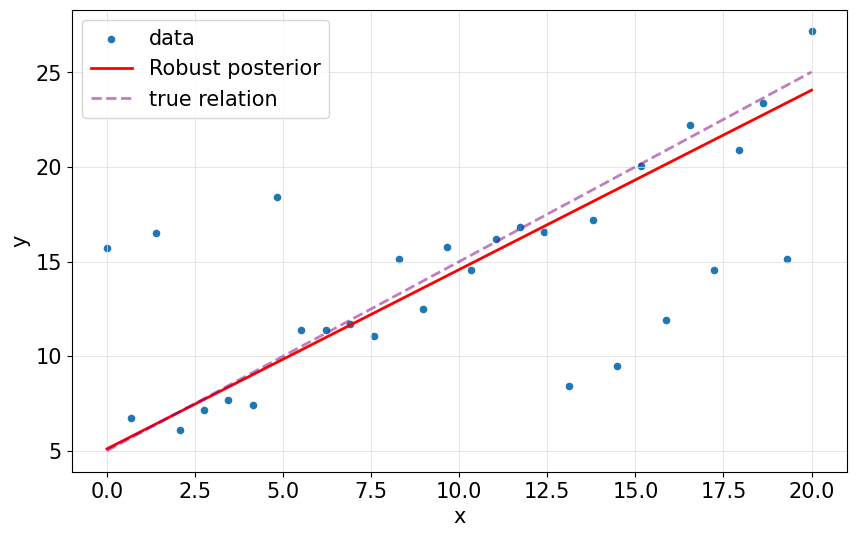

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="Robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

One can try different values for the parameter $\nu$ of the T-distribution and do a sensitivity analysis. Alternatively, one can include a hyperprior distribution for $\nu$. Gelman et al. (2003) suggests that one might try

$$ \nu^{-1} \sim {\rm Uniform}(0,1) $$

This hyperprior distribution favors long-tailed likelihoods, with half of the prior probability falling between $T(\nu=1)$ and $T(\nu=2)$.

Back to [contents](#Contents).

---

## Robust regression using the Hogg approach with PyMC

We use the same outlier dataset as in the previous example:

In [21]:
rng = np.random.default_rng(82)
N = 30
x = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * x + theta2 * (x-5)**2     # noiseless
sigma = 1.0                                      # Stdev of the noise
y = mu + rng.normal(0, sigma, N)                 # with noise
y[[0, 2, 7]] += 9                                # 3 outliers
y[[19,21,23,25,28]] -= 9                         # 5 more outliers
data = pd.DataFrame({'y': y, 'x': x})

The following code was inspired by the article of [Hogg et al. (2010)](https://arxiv.org/pdf/1008.4686v1.pdf). In particular, see their equation (17). This involves implementing a custom likelihood function using the `pm.DensityDist` feature.

In [22]:
with pm.Model() as myModel:
    
    xobs = pm.Data("xobs", x)
    yobs = pm.Data("yobs", y)
    
    sigmaInlier     = pm.HalfCauchy("sigma", beta=3)
    intercept       = pm.Normal("intercept", 0, sigma=10)
    angle           = pm.Uniform("angle", -np.pi/2, +np.pi/2)
    slope           = pm.Deterministic("slope", np.tan(angle))   
    muOutlier       = pm.Uniform("muOutlier", -100, +100, initval=0)
    logSigmaOutlier = pm.Uniform("logSigmaOutlier", -5, 5, initval=2)
    probOutlier     = pm.Uniform("probOutlier", 0.0, 1.0, initval=0.1) 
    
    def logLikelihood(y, x, sigmaInlier, intercept, angle, slope, muOutlier, logSigmaOutlier, probOutlier):
        sigmaOutlier = pt.sqrt(pt.exp(logSigmaOutlier)**2 + sigmaInlier**2) 
        muInlier = intercept + slope * x
        LikeInlier = 1./(sigmaInlier * np.sqrt(2*np.pi)) * pt.exp(-0.5 * (y - muInlier)**2 / sigmaInlier**2)
        LikeOutlier = 1./(sigmaOutlier * np.sqrt(2*np.pi)) * pt.exp(-0.5 * (y - muOutlier)**2 / sigmaOutlier**2)
        return pt.sum(pt.log((1 - probOutlier) * LikeInlier + probOutlier * LikeOutlier))

    # Exact order of the arguments in logLiklihood should be copied in DensityDist. 
    likelihood = pm.DensityDist('likelihood', xobs, sigmaInlier, intercept, angle, slope, muOutlier, 
                                logSigmaOutlier, probOutlier, logp=logLikelihood, observed=yobs)

    trace = pm.sample(4000, chains=4, cores=2, return_inferencedata=True, tune=2000, target_accept=0.95)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept, angle, muOutlier, logSigmaOutlier, probOutlier]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 15 seconds.


Note that I needed to increase the acceptance probability to 0.95. PyMC will adapt the step size such that the average acceptance probability across the trajectories is close to `target_accept`. So, higher values for `target_accept` lead to smaller step sizes.

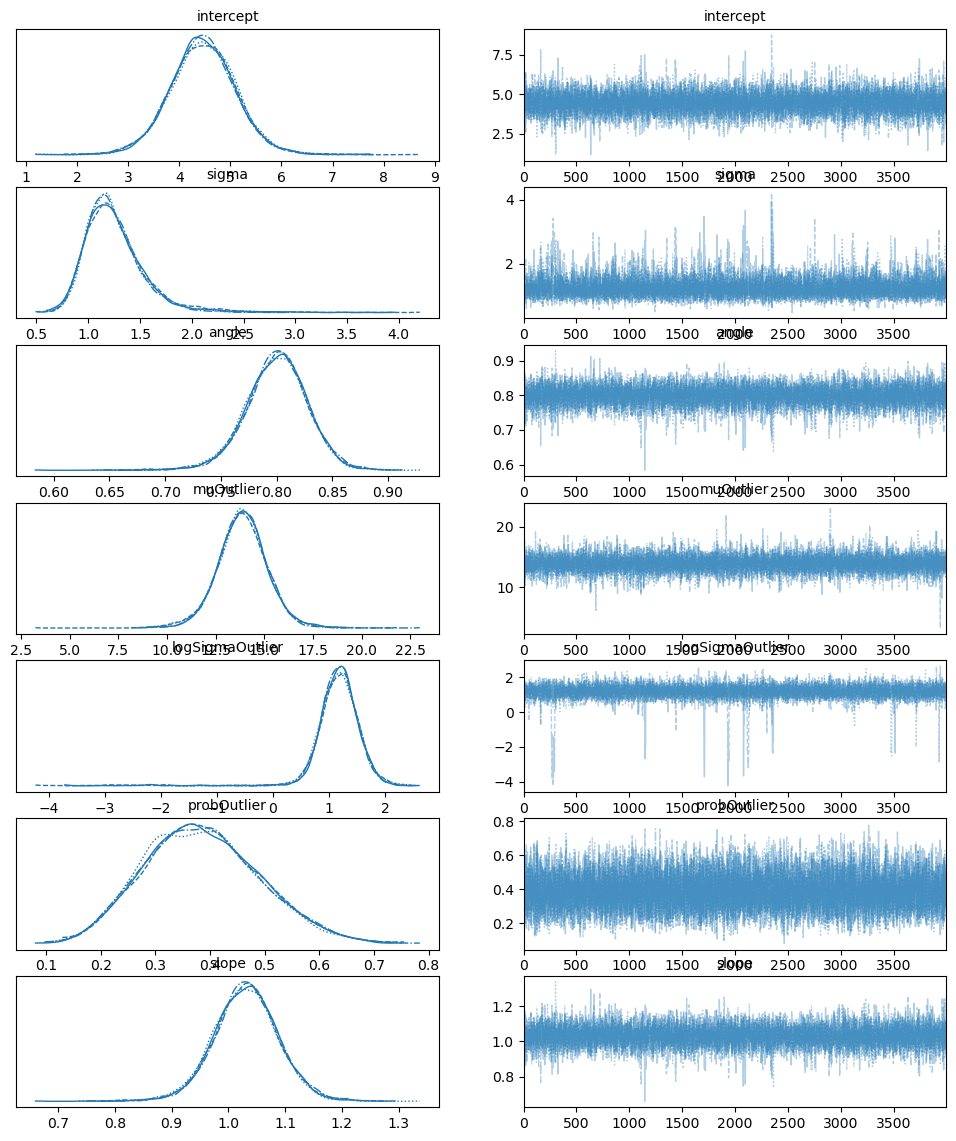

In [23]:
ax = az.plot_trace(trace)

In [24]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

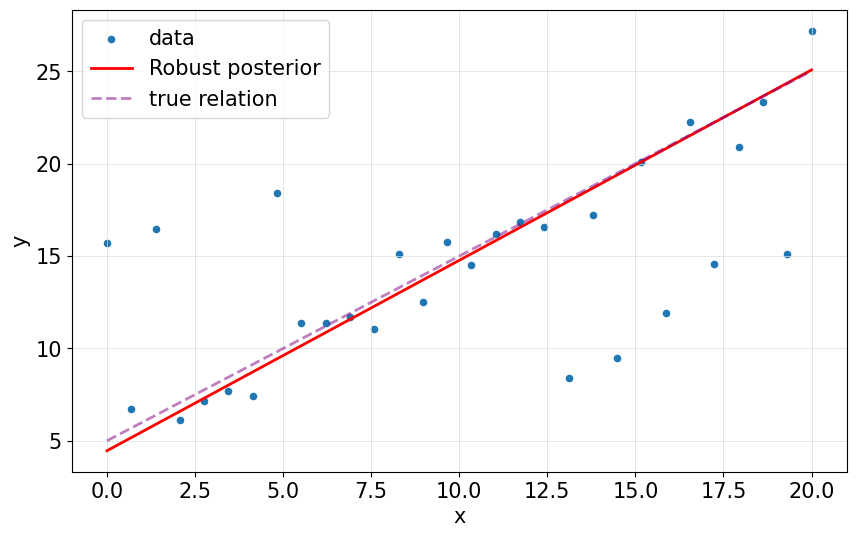

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=20, label="data")

xvalues = np.linspace(0,20,50)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, label="Robust posterior")

ytrue = theta0 + theta1 * xvalues + theta2 * (xvalues-5)**2
ax.plot(xvalues, ytrue, c="purple", linewidth=2, linestyle='--', alpha=0.5, label="true relation")

ax.legend(loc='upper left')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Piecewise linear regression with PyMC

Create an artificial dataset

In [26]:
rng = np.random.default_rng(149)

N = 50
intercept1 = 1
slope1 = 2
intercept2 = 3.275
slope2 = -1.5

sigma = 0.15

x = np.linspace(0, 2, N)

piece1 = x < 0.65
piece2 = x >= 0.65
y = np.zeros(N)
y[piece1] = intercept1 + slope1 * x[piece1] 
y[piece2] = intercept2 + slope2 * x[piece2] 
y += rng.normal(0.0, sigma, N)

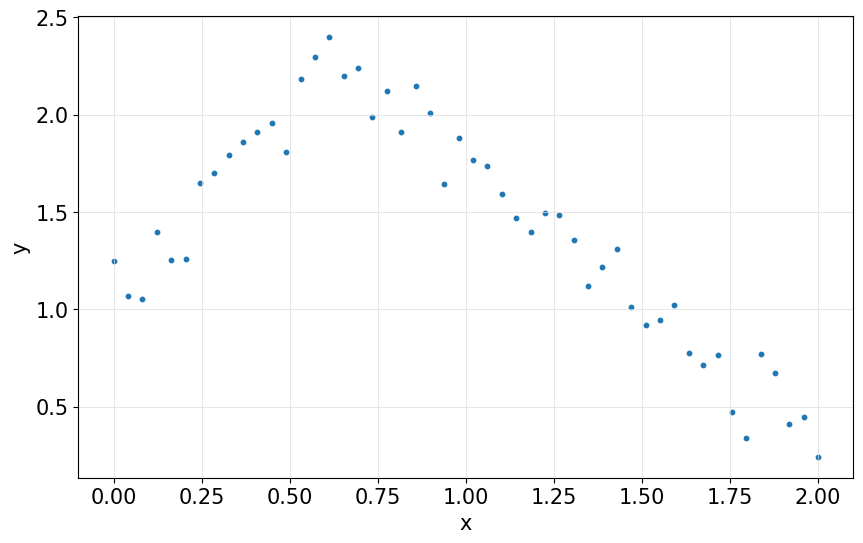

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x, y, s=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The goal is not only to derive the intercepts and the slopes of the linear pieces, but also the location of the switch point.

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$   if $x <= x_0$

$\mu = \theta_2+\theta_3 x$   if $x > x_0$

$\theta_1 = \tan(\alpha_1)$

$\theta_3 = \tan(\alpha_2)$

$\alpha_1 \sim {\rm Uniform}(0, \pi/2)$ 

$\alpha_2 \sim {\rm Uniform}(-\pi/2, 0)$ 

$\theta_0 \sim {\rm Normal}(0, 5)$

$\theta_2 \sim {\rm Normal}(0, 5)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [28]:
with pm.Model() as myModel:

    xobs        = pm.Data("xobs", x, mutable=False)
    yobs        = pm.Data("yobs", y, mutable=False)
    sigma       = pm.HalfCauchy("sigma", beta=2)
    intercept1  = pm.Normal("intercept1", 0, sigma=5)
    intercept2  = pm.Normal("intercept2", 0, sigma=5)
    angle1      = pm.Uniform("angle1", 0, +np.pi/2)
    angle2      = pm.Uniform("angle2", -np.pi/2, 0)
    slope1      = pm.Deterministic('slope1', np.tan(angle1))
    slope2      = pm.Deterministic('slope2', np.tan(angle2))
    switchpoint = pm.Normal('switchpoint', 0.6, 0.25) 
    intercept   = pm.math.switch(x <= switchpoint, intercept1, intercept2)
    slope       = pm.math.switch(x <= switchpoint, slope1, slope2)
    
    likelihood = pm.Normal("y", mu=intercept + slope * xobs, sigma=sigma, observed=yobs)

    trace = pm.sample(2000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, intercept1, intercept2, angle1, angle2, switchpoint]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 356 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


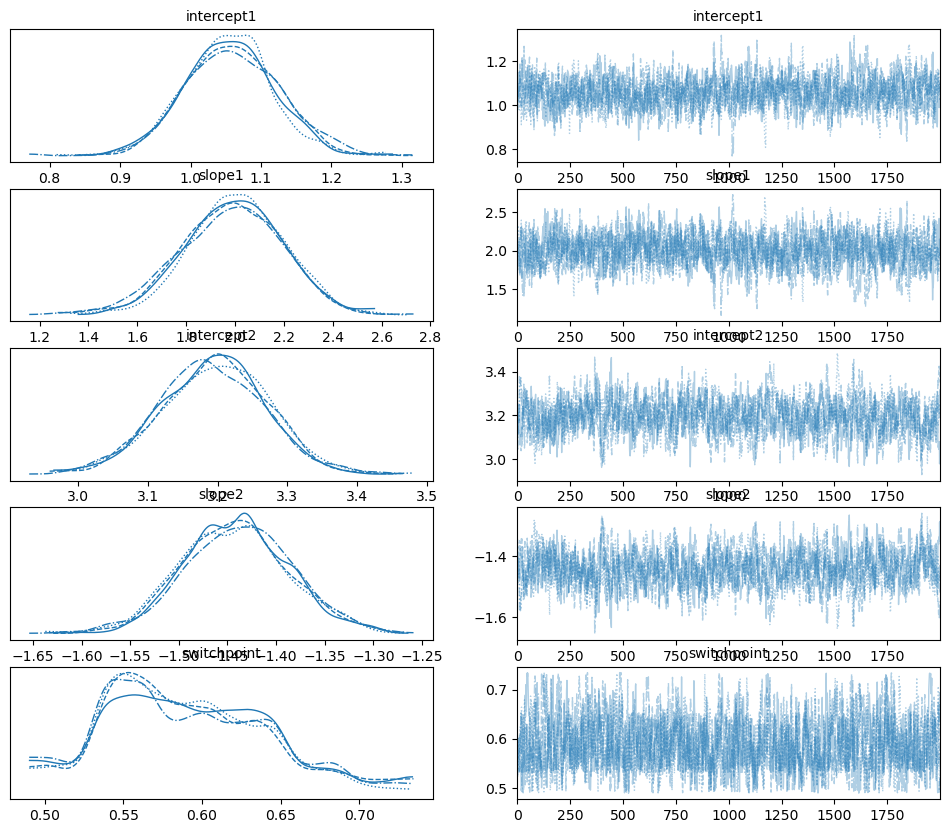

In [29]:
ax = az.plot_trace(trace, var_names=['intercept1', 'slope1', 'intercept2', 'slope2', 'switchpoint'])

In [30]:
az.summary(trace, round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept1   1.057  0.065   0.939    1.183      0.002    0.002   806.198   
intercept2   3.195  0.076   3.046    3.331      0.003    0.002   559.036   
switchpoint  0.590  0.051   0.494    0.682      0.002    0.001   914.790   
sigma        0.128  0.014   0.102    0.155      0.000    0.000   991.053   
angle1       1.102  0.043   1.024    1.178      0.002    0.001   757.625   
angle2      -0.964  0.018  -0.996   -0.928      0.001    0.001   571.526   
slope1       1.993  0.205   1.624    2.385      0.008    0.005   757.625   
slope2      -1.441  0.056  -1.537   -1.329      0.002    0.002   571.526   

             ess_tail  r_hat  
intercept1   1371.751  1.006  
intercept2   1260.916  1.009  
switchpoint  1324.206  1.003  
sigma        1664.955  1.003  
angle1       1056.318  1.006  
angle2       1291.620  1.008  
slope1       1056.318  1.006  
slope2       1291.620  1.008

Back to [contents](#Contents).

---

## Uncertainties in y and x with PyMC

We use the same dataset as above:

In [31]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/M_sigma.csv"
data = pd.read_csv(url, comment='#')
data.head()

xobs   xerr  yobs   yerr Type
0 -0.279841  0.100  6.61  0.040    S
1 -0.425969  0.015  6.46  0.090    E
2 -0.096910  0.040  8.18  0.150    S
3 -0.289883  0.094  7.00  0.300    S
4  0.019116  0.050  8.23  0.205    E

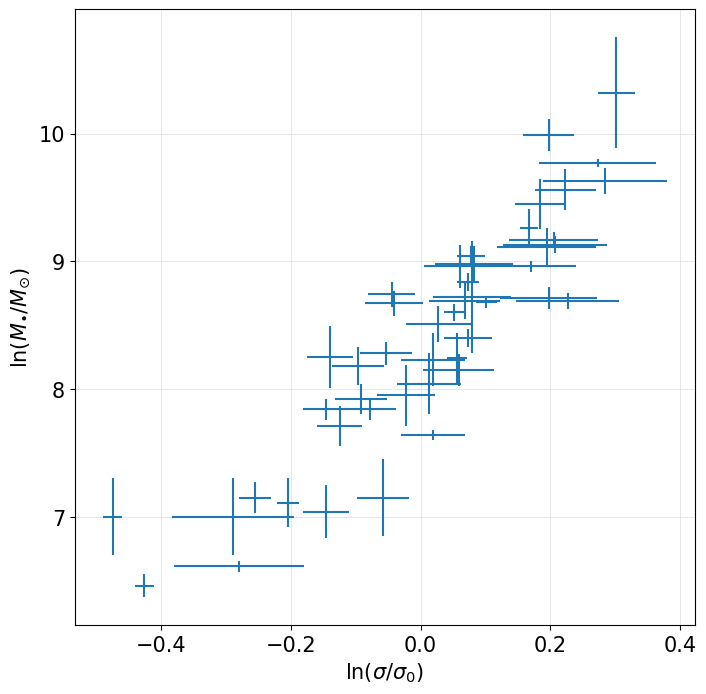

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

We assume that we know the exact relation between $x_{\rm true}$ and $y_{\rm true}$:

$ y_{\rm true} = \theta_0 + \theta_1\, x_{\rm true}  $

As before we model the measurements with errors on both $x$ and $y$ with

$ y_{\rm obs} \sim \mathcal{N}(y_{\rm true}, \sigma_y) $

$ x_{\rm obs} \sim \mathcal{N}(x_{\rm true}, \sigma_x) $

where we take $\sigma_x = {\rm xerr}$ and $\sigma_y = {\rm yerr}$, the observed uncertainties. For the prior on $x_{\rm true}$ we take an extremely broad distribution:

$ x_{\rm true} \sim \mathcal{N}(0, 20) $.


Note that PyMC allows to have two observed quantities, which we will make use of.

In [33]:
with pm.Model() as myModel:
  xobs = pm.Data('xobs', data['xobs'].values)
  yobs = pm.Data('yobs', data['yobs'].values)

  intercept = pm.Normal('intercept', 0, 20)
  alpha = pm.Uniform('alpha', 0.0, np.pi/2)
  slope = pm.Deterministic('slope', np.tan(alpha))
  true_x = pm.Normal('true_x', 0.0, 20.0, shape=len(data))
  likelihood_x = pm.Normal('x', true_x, data['xerr'].values, observed=xobs)
  true_y = pm.Deterministic('true_y', intercept + slope * true_x)
  likelihood_y = pm.Normal('y', true_y, data['yerr'].values, observed=yobs)

  trace = pm.sample(4000, chains=4, cores=2, return_inferencedata=True, tune=2000, target_accept=0.95)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, alpha, true_x]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 11 seconds.


Plot the posteriors for a sanity check:

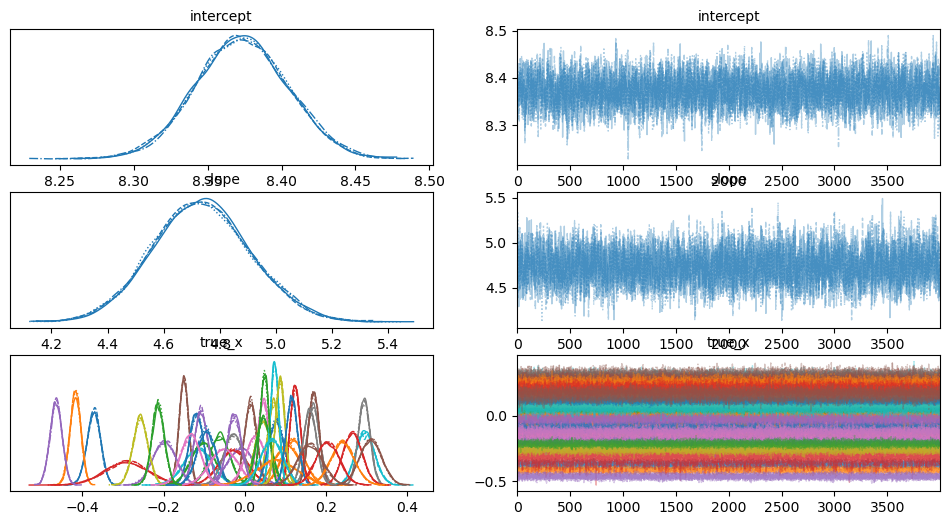

In [34]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'true_x'])

Extract the mean posterior value of the intercept and the slope to calculate the true y-values given a grid of true x-values:

In [35]:
posteriorMean = pm.summary(trace)['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope
true_x = np.linspace(-0.5, 0.4, 100)
true_y = meanIntercept + meanSlope * true_x

Overplot the mean curve on top of the data. Note that the data points use the observed x-values, while the mean curve uses the true x-values...

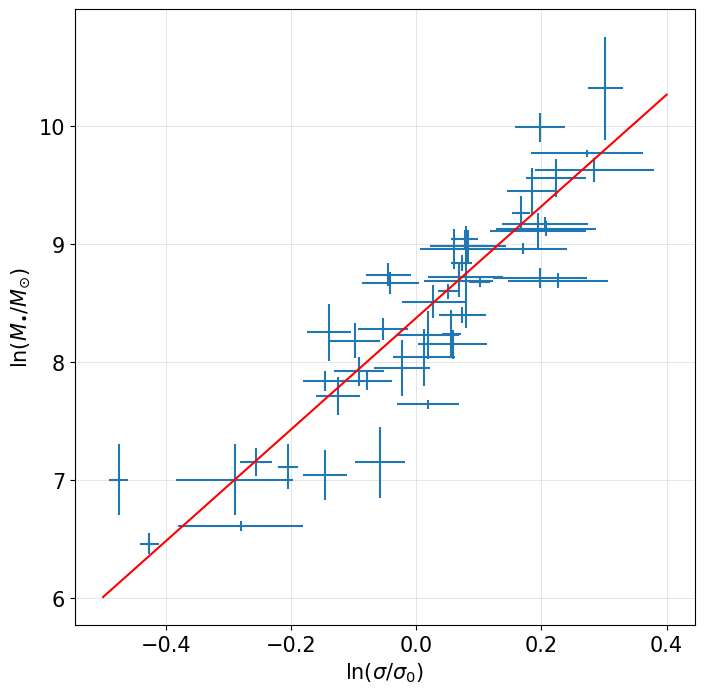

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)
ax.plot(true_x, true_y, c="red")
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling a distribution for a dataset with PyMC

Load the dataset:

In [15]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/NGC6611.csv"
data = pd.read_csv(url, comment='#')

In [16]:
data.head()

Mass
0  0.678
1  0.402
2  0.132
3  0.270
4  0.284

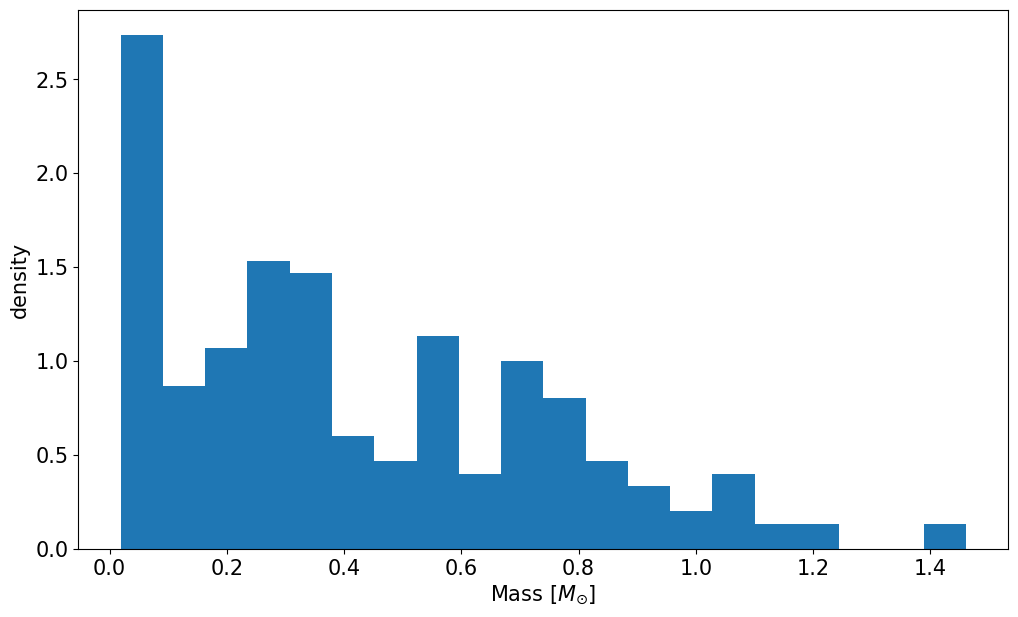

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.hist(data['Mass'].values, bins=20, density=True)
ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

We wish to fit a log-normal distribution:
    
$$f_X(x) = \frac{1}{x\sigma\sqrt{2\pi}} \ \exp\left(-\frac{(\ln x - \mu)^2}{2\sigma^2} \right)$$

$y \sim $ log-Normal $(\mu, \sigma^2)$

$\mu \sim {\rm Normal}(0, 10)$

$\sigma \sim$ HalfNormal $(0, 10^2)$

In [18]:
with pm.Model() as myModel:
    
    yobs = pm.Data("yobs", data['Mass'].values)
    
    mu         = pm.Normal("mu", mu=0, sigma=10)
    sigma      = pm.HalfNormal("sigma", sigma=10)
    likelihood = pm.Lognormal("Mass", mu=mu, sigma=sigma, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


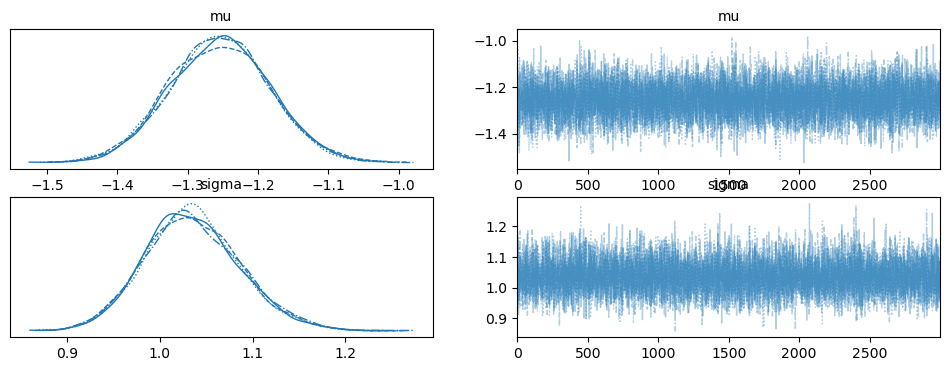

In [19]:
ax = az.plot_trace(trace)

In [20]:
az.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd   ess_bulk  \
mu    -1.255  0.071    -1.402     -1.123      0.001      0.0  12178.056   
sigma  1.035  0.051     0.936      1.138      0.000      0.0  11722.986   

       ess_tail  r_hat  
mu     9174.604  1.001  
sigma  8684.602  1.000

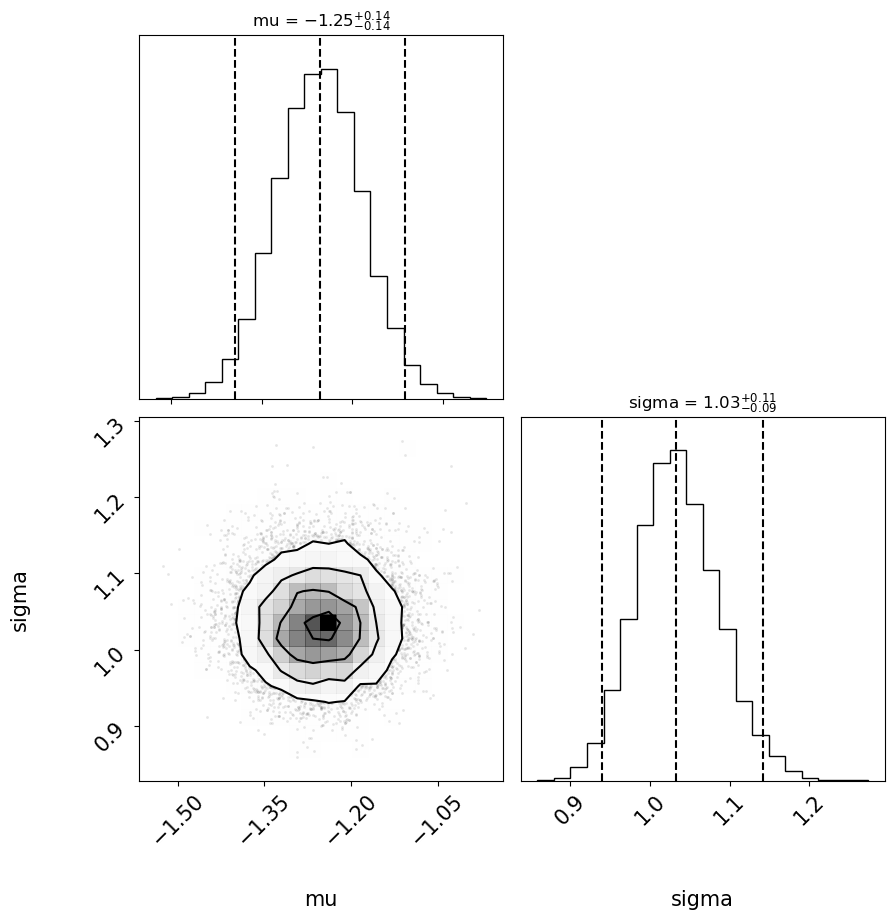

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,10))     
fig = corner.corner(trace, fig=fig, var_names=['mu', 'sigma'],
                           quantiles=[0.025, 0.5, 0.975],
                           show_titles=True, 
                           title_kwargs={"fontsize": 12})

$\mu$ and $\sigma$ seem uncorrelated.

The following aims to overplot the mean log-normal distribution over the observed density. SciPy has a bit of a deviating version of the log-normal distribution, so we need our customary function:

In [22]:
def logNormal(x, mu, sigma):
    return np.exp(-(np.log(x) - mu)**2/2/sigma**2) / x / sigma / np.sqrt(2*np.pi)

In [23]:
meanValues = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['mean']
muMean = meanValues.mu
sigmaMean = meanValues.sigma

lowerQuantiles = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['hdi_2.5%']
muLower = lowerQuantiles.mu
sigmaLower = lowerQuantiles.sigma

upperQuantiles = pm.summary(trace, var_names=['mu', 'sigma'], hdi_prob=0.95)['hdi_97.5%']
muUpper = upperQuantiles.mu
sigmaUpper = upperQuantiles.sigma

In [24]:
sigmaUpper

1.138

In [25]:
xvalues = np.linspace(0.01, 1.5, 100)
yvaluesMean  = logNormal(xvalues, muMean, sigmaMean)
yvaluesLower = logNormal(xvalues, muLower, sigmaLower)
yvaluesUpper = logNormal(xvalues, muUpper, sigmaUpper)

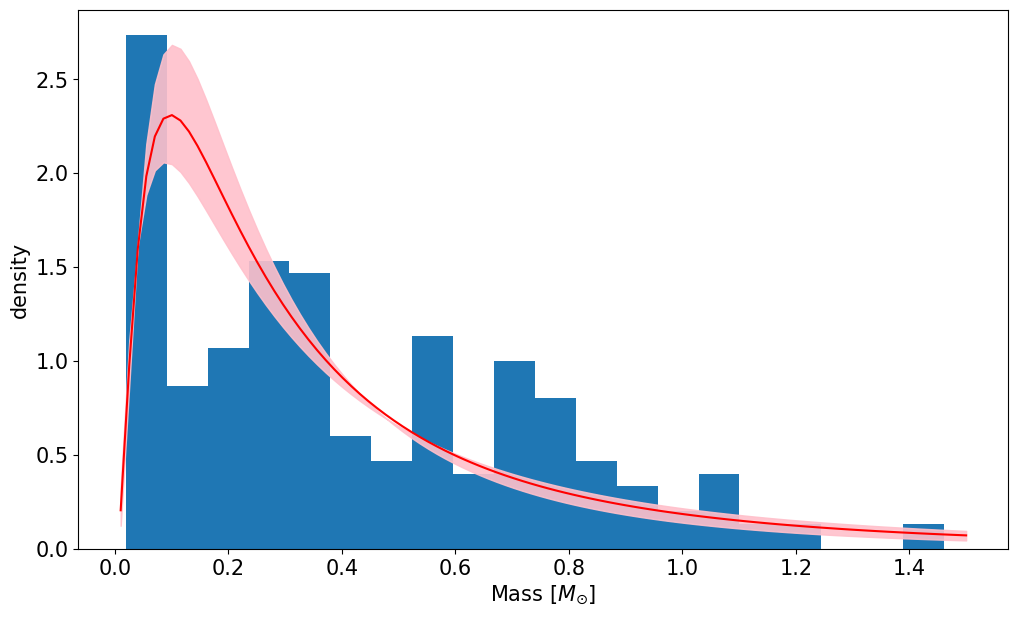

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.hist(data['Mass'].values, bins=20, density=True)

ax.fill_between(xvalues, yvaluesLower, yvaluesUpper, color="pink", alpha=0.9)
ax.plot(xvalues, yvaluesMean, c="red", linewidth=1.5)

ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

Back to [contents](#Contents).

---

## Modeling a fraction with PyMC

In [12]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/f_gas.csv"
data = pd.read_csv(url, comment='#')
data.head()

NSAID           RA           DEC   DISTANCE  DISTANCE_ERR  INCLINATION  \
0    162  09:58:30.23  +00:02:42.72  30.230679      1.893556           71   
1   1443  12:23:09.98  +00:25:37.76  35.361080      2.000777           68   
2   5109  22:30:36.80  -00:06:37.01  21.256725      1.857816           28   
3   5378  23:06:39.16  +00:34:41.02  68.131355      2.393957           70   
4   5424  23:14:19.43  +00:10:59.36  60.297279      1.750601           88   

      V_W20I  V_W20I_ERR     R_EFF  R_EFF_ERR          M_HI     M_HI_ERR  \
0  40.484997    3.175172  0.718135   0.044982  1.051982e+08   29240232.0   
1  26.163080   13.456303  0.863503   0.048858  4.139277e+07   18685420.0   
2  77.564659    3.161093  0.285932   0.024990  6.664611e+07   24189620.0   
3  61.939968    2.134023  1.818062   0.063882  1.039202e+09  166114256.0   
4  63.627235    3.002364  1.771058   0.051419  4.048609e+08   58240672.0   

        M_STAR   M_STAR_ERR  SOURCE  
0   16153380.0    7440246.5       1  
1   43087828.0   19846254.0       1  
2    7706057.5    3549410.0       3  
3  273271296.0  125868760.0       1  
4  611754560.0  281774176.0       1

In [13]:
x = np.log10(data['M_STAR'].values)
y = data['M_HI'].values / (data['M_HI'].values + data['M_STAR'].values)               # gas fraction
isorted = np.argsort(x)
x = x[isorted]
y = y[isorted]

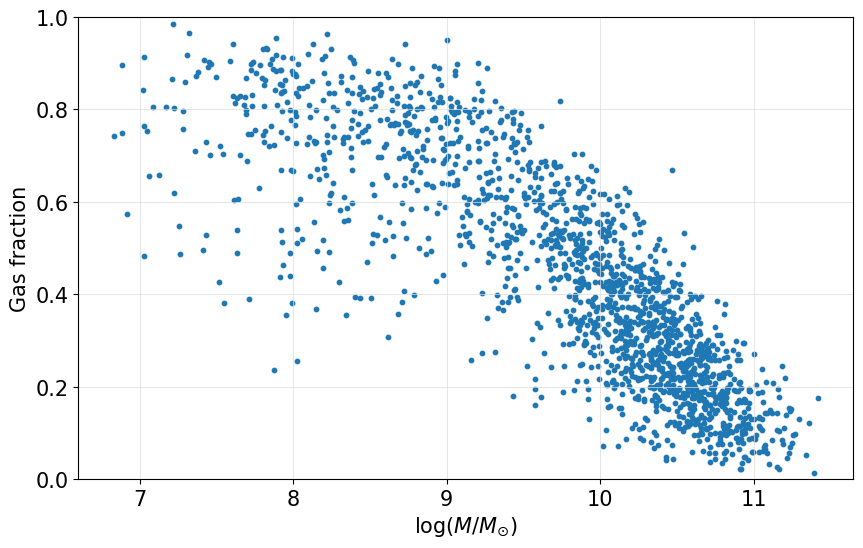

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(x, y, s=10)
ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(0,1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

In [16]:
with pm.Model() as myModel:
    
    xobs = pm.Data("xobs", x, mutable=False)
    yobs = pm.Data("yobs", y, mutable=False)
    
    intercept = pm.Normal("intercept", 0, 5)
    slope = pm.Normal("slope", 0, 5)
    nu = pm.HalfCauchy("nu", beta=4)
    mu = pm.Deterministic('mu', pm.math.sigmoid(intercept + slope * xobs))
    likelihood = pm.Beta("gasfraction", mu=mu, nu=nu, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope, nu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 51 seconds.


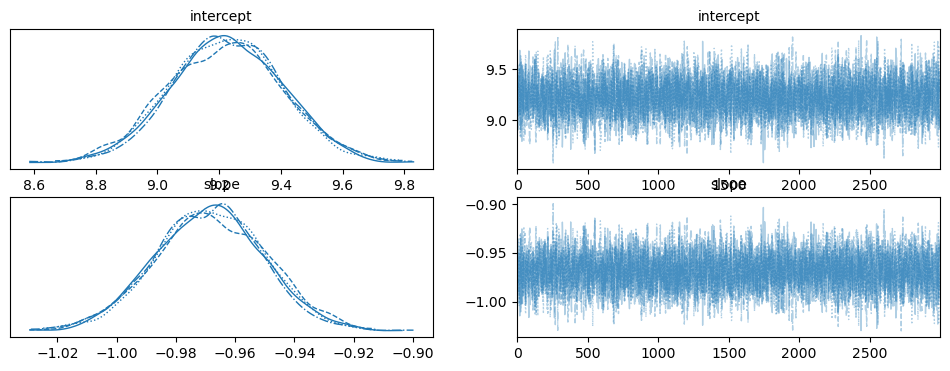

In [17]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

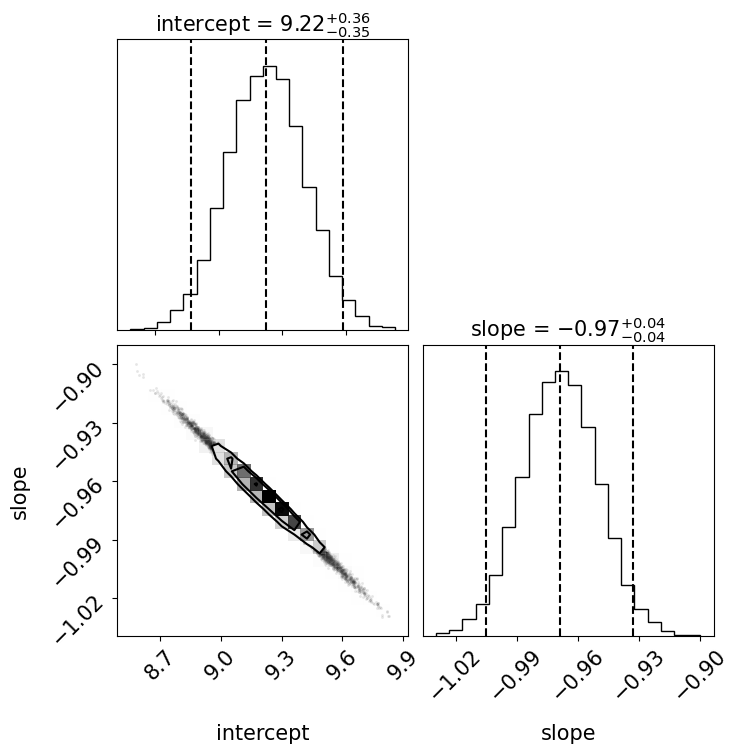

In [18]:
fig, ax = plt.subplots(2,2, figsize=(8,8))     
fig = corner.corner(trace, fig=fig, var_names=['intercept', 'slope'], quantiles=[0.025, 0.5, 0.975], show_titles=True, kwrgs={"fontsize": 12})

To compute the uncertainty band around the mean curve, we compute the curve corresponding to the lower boundary of the HDI intervals of the model parameters, and the curve corresponding to the upper boundary of the model parameters.

In [31]:
meanValues = pm.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95)['mean']
interceptMean = meanValues.intercept
slopeMean = meanValues.slope

lowerHDI = pm.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95)['hdi_2.5%']
interceptLower = lowerHDI.intercept
slopeLower = lowerHDI.slope

upperHDI = pm.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95)['hdi_97.5%']
interceptUpper = upperHDI.intercept
slopeUpper = upperHDI.slope

muMean = expit(interceptMean + slopeMean * x)
muLower = expit(interceptLower + slopeLower * x)
muUpper = expit(interceptUpper + slopeUpper * x)

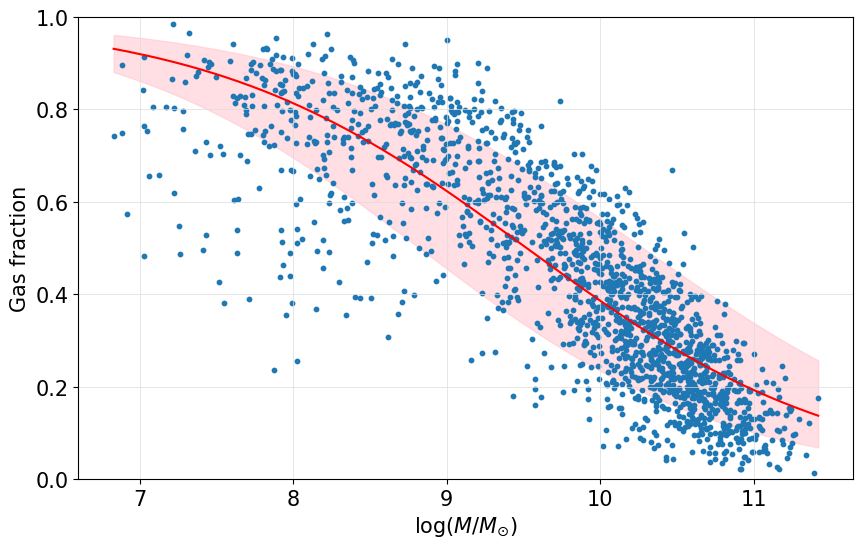

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(x, muMean, c="red")
ax.fill_between(x, muLower, muUpper, color="pink", alpha=0.5)
ax.scatter(x, y, s=10)

ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(0,1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

---

## Fitting a binomial logistic model with PyMC

We use the same dataset as in the previous example:

In [49]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/Red_spirals.csv"
data = pd.read_csv(url, comment='#')
data.head()

redshift    g_r  g_r_err  fracdev  type
0    0.0833  0.695    0.020     0.42     1
1    0.0735  0.701    0.021     0.46     1
2    0.0642  0.756    0.039     0.00     1
3    0.0621  0.662    0.017     0.32     1
4    0.0661  0.687    0.018     0.40     1

In [50]:
with pm.Model() as myModel:
    xobs = pm.Data("xobs", data['fracdev'].values)
    yobs = pm.Data("yobs", data['type'].values)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope     = pm.Normal('slope', mu=0, sigma=10)
    probRed   = pm.Deterministic('probRed', pm.math.sigmoid(intercept + slope * xobs))
    y         = pm.Bernoulli('y', p=probRed, observed=yobs)

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 10 seconds.


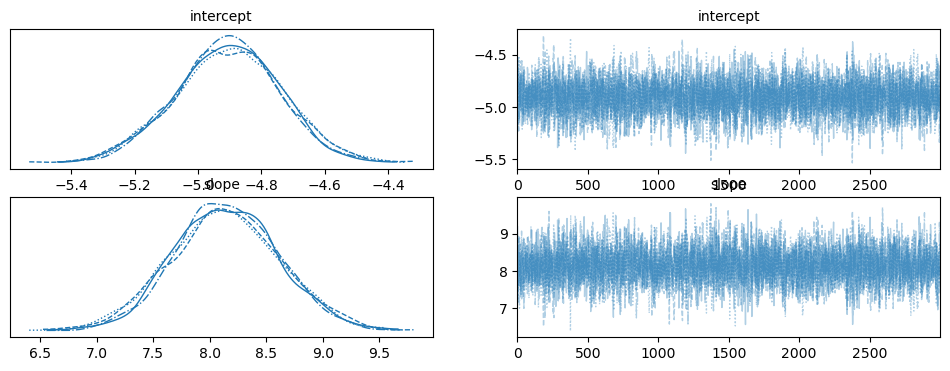

In [51]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope'])

In [52]:
az.summary(trace, var_names=['intercept', 'slope'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept -4.906  0.166    -5.257     -4.606      0.003    0.002  3409.334   
slope      8.141  0.474     7.192      9.051      0.008    0.006  3313.218   

           ess_tail  r_hat  
intercept  3231.510  1.002  
slope      3266.752  1.001

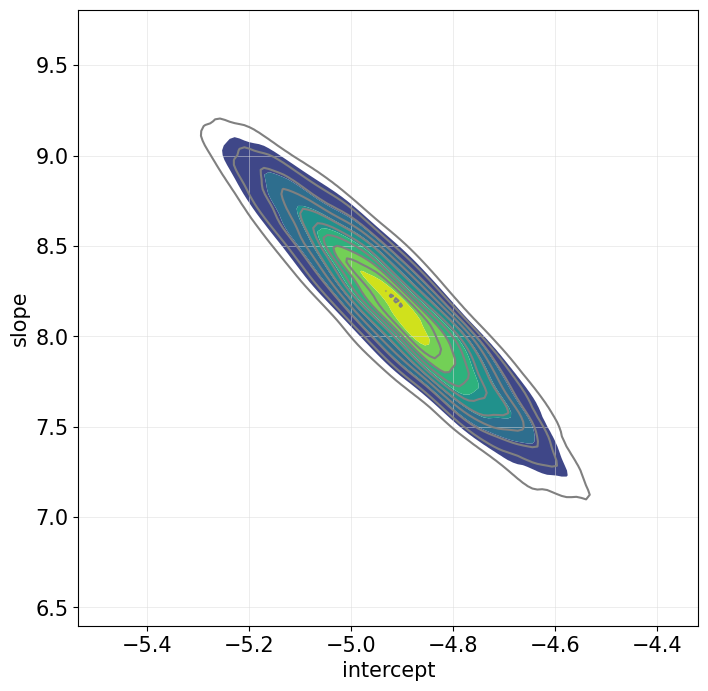

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
kde_kwargs = {'contour_kwargs': {'levels': 10}}
az.plot_pair(trace, ax=ax, var_names=['intercept', 'slope'], kind='kde', kde_kwargs=kde_kwargs);
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5, alpha=0.7)

The mean fit:

In [54]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope
xvalues = np.linspace(0, 0.5, 100)
yvalues = 1/(1+np.exp(-meanIntercept-meanSlope*xvalues))

In [55]:
stacked = trace.posterior.stack(draws=("chain", "draw"))
slope = stacked.slope.values
intercept = stacked.intercept.values

The observed fraction of red spirals w.r.t. the total number of spiral galaxies:

In [56]:
bins = np.linspace(0, 0.5, 20)
binCenters = (bins[1:] + bins[:-1])/2.

red = data['type'] == 1
allGalaxies, dummy = np.histogram(data['fracdev'], bins=bins)
redGalaxies, dummy = np.histogram(data.loc[red, 'fracdev'], bins=bins) 
fraction = redGalaxies / allGalaxies

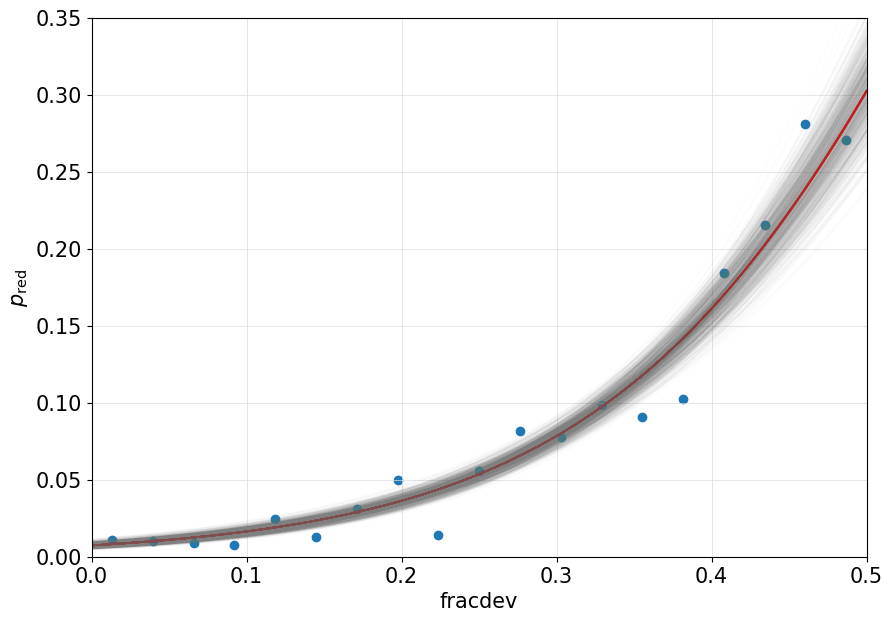

In [57]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(xvalues, yvalues, c="red", linewidth=2)

M = len(slope)//1000
for n in range(0, len(slope), M):
    yvalues = 1/(1+np.exp(-intercept[n]-slope[n]*xvalues))
    ax.plot(xvalues, yvalues, c="gray", linewidth=1, alpha=0.02)

ax.scatter(binCenters, fraction)

ax.set_xlabel("fracdev")
ax.set_ylabel(r"$p_{\rm red}$")
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.35)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## A multinomial logistic model with PyMC

To give an example on how to model a multinomial logistic model with PyMC we will first make a synthetic dataset, as this will be instructive on its own.

As before we have 3 classes, and a parameter 'x' that we can measure for each object we study. The probability that an object belongs to a particular class depends on its measured x-values. We aim to put forward a model for this dependence, and get posterior distributions for the model parameters.

The reason why it's called a "multinomial" model is that we will model the data with a Multinomial probability distribution:

$$ y_i \sim {\rm MultiNom}(N, \ \{p_1, p_2, \cdots, p_k\}) $$

Here $k$ is the number of classes (in our example k=3), $p_j$ is the probability for an object to belong to class $j$. $N$ is called the number of "trials" or "number of experiments", when observations are done in batches. 

For example, for the case of 3 classes with probabilities $(p_1, p_2, p_3) = (0.2, 0.3, 0.5)$ and N=100 trials we can draw a Multinomial datapoint using Numpy:

In [58]:
rng = np.random.default_rng(1984)
y = rng.multinomial(100, [0.2, 0.3, 0.5])
print(y)

[17 26 57]


The drawn datapoint tells us that of the 100 trials, we got 17 objects of class 1, 26 objects of class 2, and 57 objects of class 3, which is pretty consistent with the probabilities we entered.

The Multinomial distribution is a very general distribution that reduces to some other distributions for specific values of $N$ and $k$:
* If $k=2$ and $N=1$, the multinomial distribution reduces to the _Bernoulli distribution_.
* If $k=2$ and $N>1$, we obtain the _Binomial distribution_.
* If $k>2$ and $N=1$, the multinomial distribution is also called the _Categorical distribution_. This is the case for the current example, as we observe just one star at a time.

For example, for $k=3$ and $N=1$, we can draw 5 objects from the Multinomial distribution using:

In [59]:
rng = np.random.default_rng(9084)
y = rng.multinomial(1, [0.2, 0.3, 0.5], size=5)
print(y)

[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


The first row $[1, 0, 0]$ means 1 object of class 1, and 0 objects of classes 2 and 3. That is, an object of class 1. So, the array above is equivalent with:

In [60]:
["class1", "class3", "class3", "class2", "class2"]

['class1', 'class3', 'class3', 'class2', 'class2']

or if we assign the numbers 0, 1, and 2 to respectively classes 1, 2, and 3, it's equivalent to:

In [61]:
[0,2,2,1,1]

[0, 2, 2, 1, 1]

The latter form is usually how our observed dataset looks like.

We will use for each of the probabilities $p_j$ a linear model:

$$ \alpha_j + \beta_j x. $$

You might be tempted to use the logistic function to map this quantity into a probability $\in [0,1]$:

$$ p_j(x) = \frac{1}{1+e^{-\alpha_j - \beta_j x}}  \ \ \ \ \ \ \ \ \ (??)$$

However, this does not take into account that the probabilities should add up to one: $p_1 + p_2 + p_3 = 1$. Instead, what is usually done is to model:

$$ \ln\left(\frac{p_2}{p_1}\right) = \alpha_2 + \beta_2 x $$
$$ \ln\left(\frac{p_3}{p_1}\right) = \alpha_3 + \beta_3 x $$

and then use the fact that the probabilities add up to 1 to derive that:

$$p_1(x) = \frac{1}{1+e^{\alpha_2 + \beta_2 x}+e^{\alpha_3+\beta_3 x}} $$
$$p_2(x) = \frac{e^{\alpha_2 + \beta_2 x}}{1+e^{\alpha_2 + \beta_2 x}+e^{\alpha_3+\beta_3 x}} = p_1 \ e^{\alpha_2 + \beta_2 x} $$
$$p_3(x) = \frac{e^{\alpha_3+\beta_3 x}}{1+e^{\alpha_2 + \beta_2 x}+e^{\alpha_3+\beta_3 x}} = p_1 \ e^{\alpha_3 + \beta_3 x} $$


With this knowledge we can generate our synthetic dataset:

In [62]:
rng = np.random.default_rng(1984)

# Some arbitrarily chosen observed x-values

xobs= np.sort(rng.uniform(-1.7, 1.5, size=50))

# Generate the probabilities to belong to classes 1, 2, or 3

exp2 = np.exp(0.0 + 4.0 * xobs) 
exp3 = np.exp(0.1 - 3* xobs) 
p1 = 1 / (1+exp2+exp3)
p2 = exp2 * p1 
p3 = exp3 * p1 
p = np.array([p1,p2,p3]).transpose()                             # This is the format the numpy's multinomial function expects

# Generate the data

yobs = rng.multinomial(1, p)                                     # N=1 trial, but since we gave it 50 (p_1, p_2, p_3) triplets, it will generate 50 data points
print(yobs[:5])

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


To transform these observations that what a typical dataset looks like, I use the trick:

In [63]:
observed_class = np.sum(yobs * [1, 2, 3], axis=1) - 1
print(observed_class)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 0 1 2 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


Here the numbers 0, 1, and 2, denote classes 1, 2, and 3. Why not use the numbers 1,2,3? See below: some library functions expect class numbers starting from 0. 

So we now have 50 objects, each with a measured 'x' value, drawn with a probability to belong to a certain class depending on that x-value.

We can illustrate our dataset with the following figure:

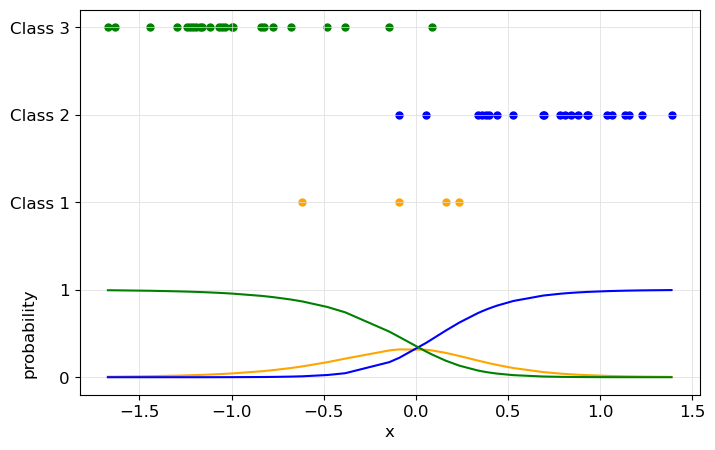

In [64]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xobs, p1, c="orange")
ax.plot(xobs, p2, c="blue")
ax.plot(xobs, p3, c="green")

class1 = observed_class == 0
ax.scatter(xobs[class1], observed_class[class1]+2, c="orange", s=25)
class2 = observed_class == 1
ax.scatter(xobs[class2], observed_class[class2]+2, c="blue", s=25)
class3 = observed_class == 2
ax.scatter(xobs[class3], observed_class[class3]+2, c="green", s=25)

plt.show()

The probability curves are the true (but unknown) ones that we used to generate this synthetic dataset.

Our PyMC model is quite easy, but you have to remember to use `pytensor` rather than `numpy` to derive the probabilities. As before, note the `transpose()` to reshape the array into the shape that `pm.Multinomial` expects.

In [65]:
with pm.Model() as myModel:

    intercept2 = pm.Normal('intercept2', mu=0, sigma=10)
    slope2     = pm.Normal('slope2',     mu=0, sigma=10)
    intercept3 = pm.Normal('intercept3', mu=0, sigma=10)
    slope3     = pm.Normal('slope3',     mu=0, sigma=10)

    exp2 = pt.exp(intercept2+slope2*xobs)
    exp3 = pt.exp(intercept3+slope3*xobs)
    p1 = 1.0 / (1.0 + exp2+exp3)
    p2 = exp2 * p1
    p3 = exp3 * p1
    p = pt.transpose([p1,p2,p3])
    
    likelihood = pm.Multinomial('y', n=1, p=p, observed=yobs)
    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept2, slope2, intercept3, slope3]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


And here are the posteriors:

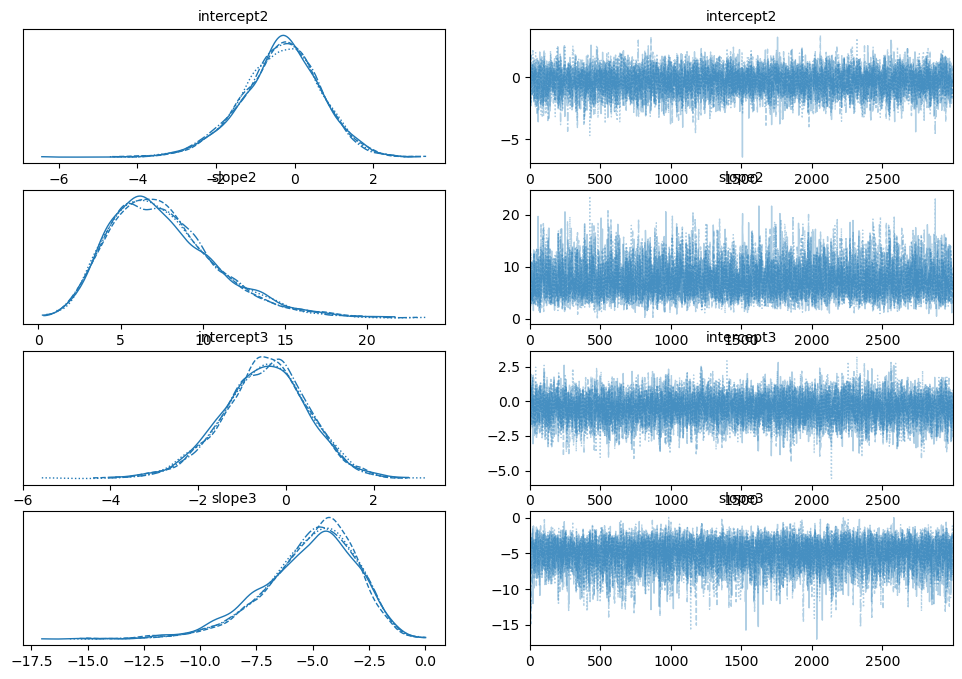

In [66]:
ax = az.plot_trace(trace, var_names=['intercept2', 'slope2', 'intercept3', 'slope3'])

Note that large uncertainties of our model parameters. This also shows in the posterior summary:

In [67]:
az.summary(trace, hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept2 -0.351  1.009    -2.432      1.551      0.014    0.010  5464.653   
slope2      7.590  3.235     2.187     14.308      0.046    0.033  5427.607   
intercept3 -0.474  0.985    -2.420      1.436      0.013    0.009  5989.648   
slope3     -5.131  2.100    -9.318     -1.437      0.030    0.022  5447.910   

            ess_tail  r_hat  
intercept2  6070.194  1.000  
slope2      5536.947  1.000  
intercept3  6190.546  1.000  
slope3      5200.764  1.001

To plot the probability distributions on top of our dataset, we first extract the mean values for the intercepts and the slopes:

In [68]:
posteriorMean = az.summary(trace)['mean']
mean_intercept2 = posteriorMean.intercept2
mean_slope2 = posteriorMean.slope2
mean_intercept3 = posteriorMean.intercept3
mean_slope3 = posteriorMean.slope3


This allows us to compute a mean distribution for each of the $p_j(x)$:

In [69]:
xvalues = np.linspace(-1.7, 1.5, 100)
exp2 = np.exp(mean_intercept2 + mean_slope2 * xvalues)
exp3 = np.exp(mean_intercept3 + mean_slope3 * xvalues)
mean_p1 = 1.0 / (1.0 + exp2+exp3)
mean_p2 = exp2 * mean_p1
mean_p3 = exp3 * mean_p1

leading to the following figure:

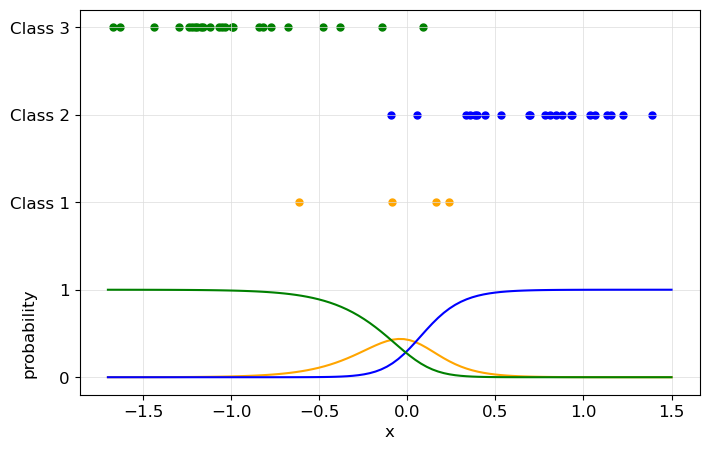

In [70]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xvalues, mean_p1, c="orange")
ax.plot(xvalues, mean_p2, c="blue")
ax.plot(xvalues, mean_p3, c="green")

class1 = observed_class == 0
ax.scatter(xobs[class1], observed_class[class1]+2, c="orange", s=25)
class2 = observed_class == 1
ax.scatter(xobs[class2], observed_class[class2]+2, c="blue", s=25)
class3 = observed_class == 2
ax.scatter(xobs[class3], observed_class[class3]+2, c="green", s=25)


plt.show()

In our `PyMC` model we used the observations `yobs`. For a synthetic dataset this particular form of data is easily derived, but for a real-life dataset we usually have something similar as `observed_class`. Isn't there an easier way so that we can just use the latter? There is indeed: by using the `pm.Categorical` distribution:

In [71]:
with pm.Model() as myModel:

    intercept2 = pm.Normal('intercept2', mu=0, sigma=10)
    slope2     = pm.Normal('slope2',     mu=0, sigma=10)
    intercept3 = pm.Normal('intercept3', mu=0, sigma=10)
    slope3     = pm.Normal('slope3',     mu=0, sigma=10)

    exp2 = pt.exp(intercept2+slope2*xobs)
    exp3 = pt.exp(intercept3+slope3*xobs)
    p1 = 1.0 / (1.0 + exp2+exp3)
    p2 = exp2 * p1
    p3 = exp3 * p1
    p = pt.transpose([p1,p2,p3])
    
    likelihood = pm.Categorical('y', p, observed=observed_class)
    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept2, slope2, intercept3, slope3]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


leading to similar posteriors:

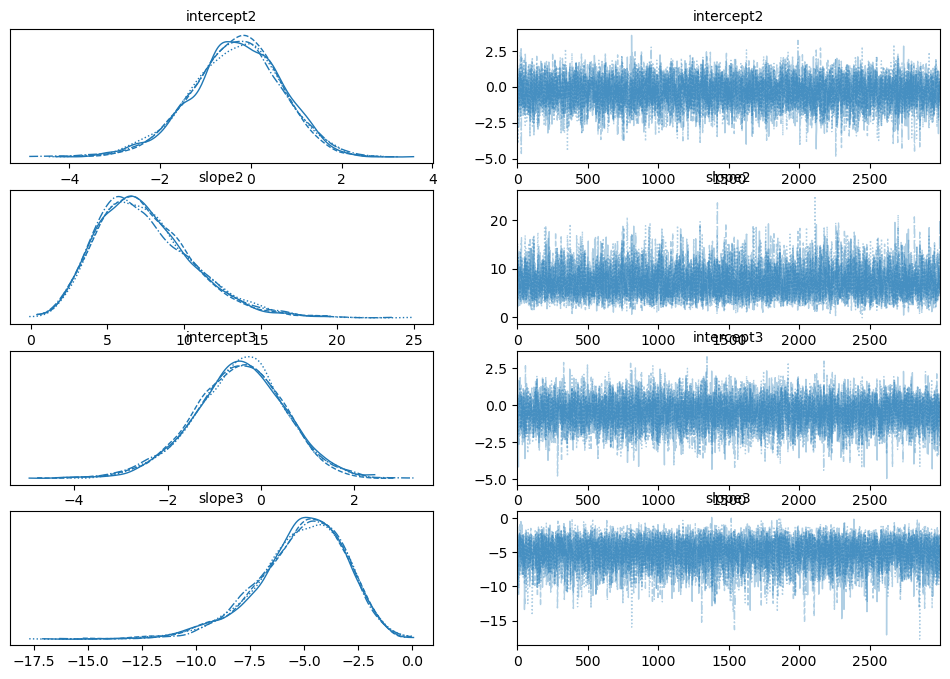

In [72]:
ax = az.plot_trace(trace, var_names=['intercept2', 'slope2', 'intercept3', 'slope3'])

Back to [contents](#Contents).

---

## Modeling counts with Poisson with PyMC

In [73]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')
data.head()

N_GC   MV_T Type
0   160 -21.30    S
1     1 -14.84  Irr
2   150 -20.18    S
3    36 -18.77    S
4    10 -15.46    E

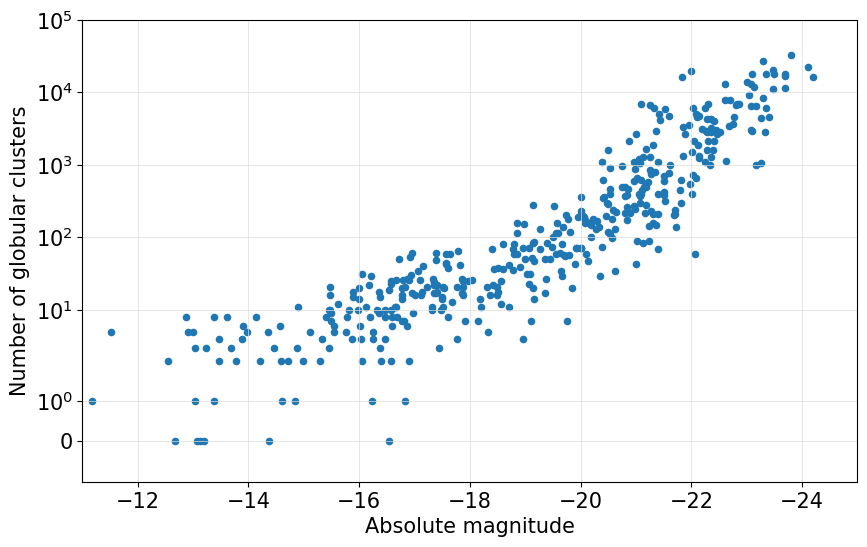

In [74]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(data['MV_T'], data['N_GC'], s=20)
ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The PyMC model:

In [75]:
with pm.Model() as myModel:
    xobs = pm.Data("xobs", data['MV_T'].values)
    yobs = pm.Data("yobs", data['N_GC'].values)
    intercept  = pm.Normal('intercept', mu=0, sigma=40)
    slope      = pm.Normal('slope', mu=0, sigma=40)
    mu         = np.exp(intercept + slope * xobs)
    y          = pm.Poisson('y', mu=mu, observed=yobs)

    N = len(data['N_GC'].values)
    K = 2
    dispersion = pm.Deterministic('dispersion', pt.sum((yobs-mu)**2 / mu) / (N-K))

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=3941592)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 11 seconds.


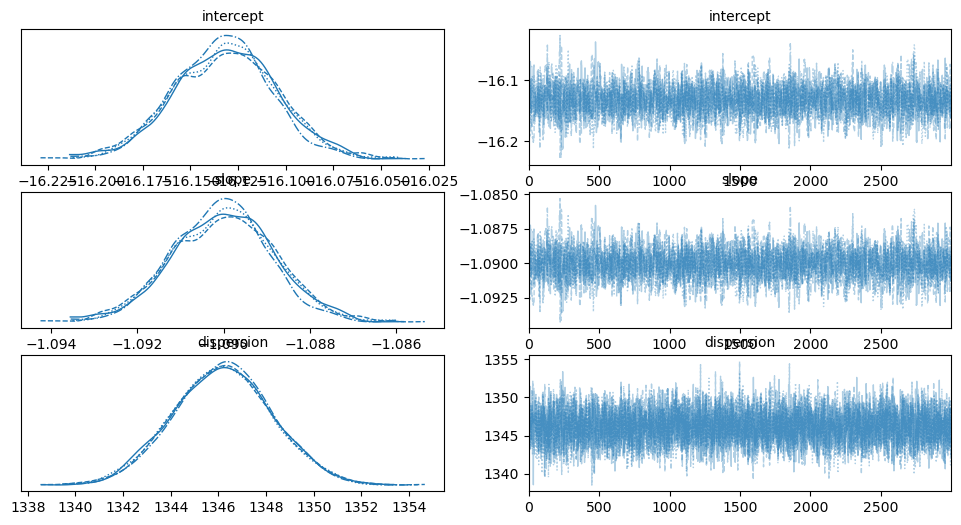

In [76]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'dispersion'])

In [77]:
az.summary(trace, var_names=['intercept', 'slope', 'dispersion'], hdi_prob=0.95, round_to=3)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept    -16.132  0.027   -16.184    -16.079      0.001    0.000   
slope         -1.090  0.001    -1.092     -1.088      0.000    0.000   
dispersion  1346.179  2.062  1341.925   1349.979      0.031    0.022   

            ess_bulk  ess_tail  r_hat  
intercept   1973.251  1642.380  1.003  
slope       1973.346  1622.202  1.003  
dispersion  4320.485  5149.293  1.000

In [78]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

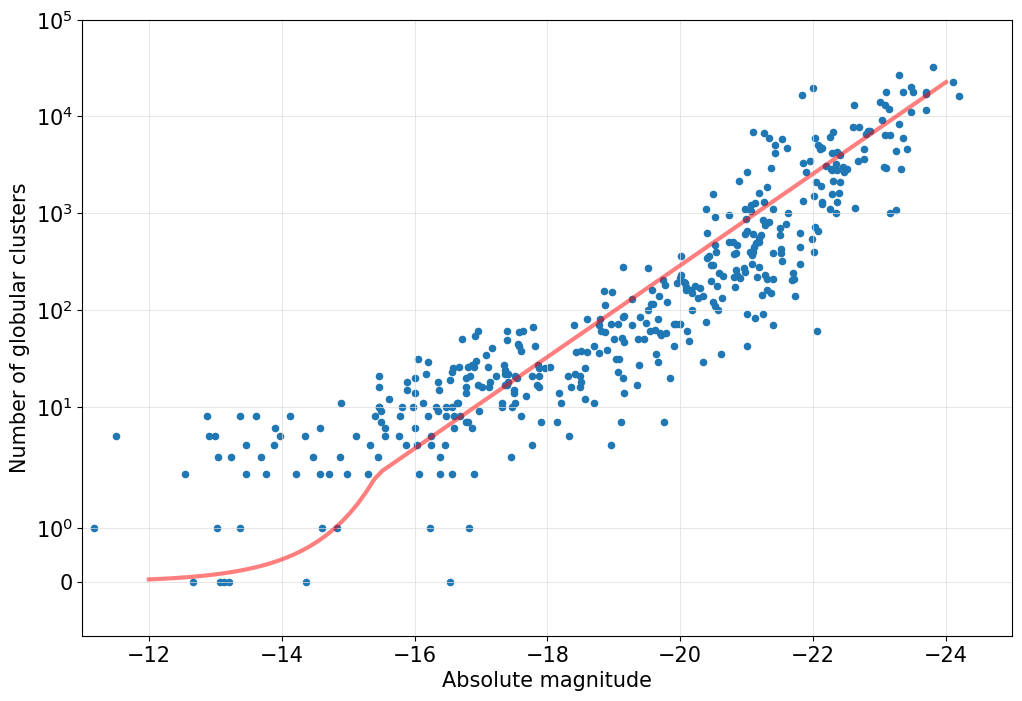

In [79]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(data['MV_T'], data['N_GC'], s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1.0, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Negative Binomial with PyMC

In [80]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')

In [81]:
with pm.Model() as myModel:
    
    xobs       = pm.Data("xobs", data['MV_T'].values)
    yobs       = pm.Data("yobs", data['N_GC'].values)
    intercept  = pm.Normal('intercept', mu=0, sigma=40)
    slope      = pm.Normal('slope', mu=0, sigma=40)
    mu         = np.exp(intercept + slope * xobs)
    alpha      = pm.Uniform('alpha', 0, 5)
    y          = pm.NegativeBinomial('y', mu=mu, alpha=alpha, observed=yobs)
    var        = pm.Deterministic('variance', mu * (1+mu/alpha))

    N = len(data['N_GC'].values)
    K = 3
    dispersion = pm.Deterministic('dispersion', pt.sum((yobs-mu)**2 / var) / (N-K))

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=341592)

/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, slope, alpha]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.


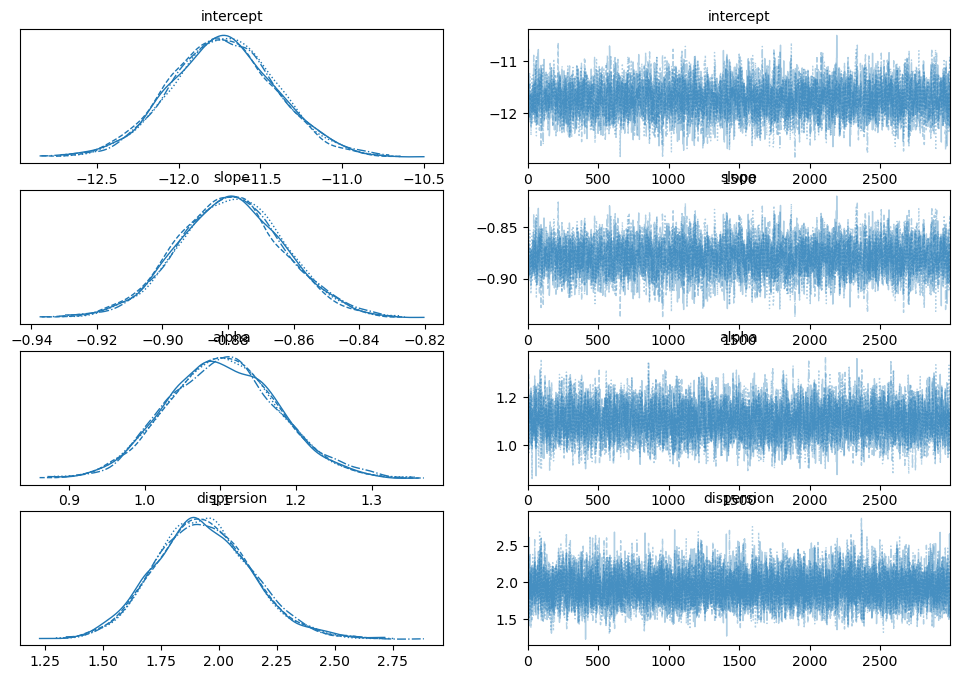

In [82]:
ax = az.plot_trace(trace, var_names=['intercept', 'slope', 'alpha', 'dispersion'])

The model is still slightly overdispersed, but we can't exclude that this is caused by the fact that we somewhat misspecified our model. 

In [83]:
posteriorMean = pm.summary(trace, var_names=['intercept', 'slope'])['mean']
meanIntercept = posteriorMean.intercept
meanSlope = posteriorMean.slope

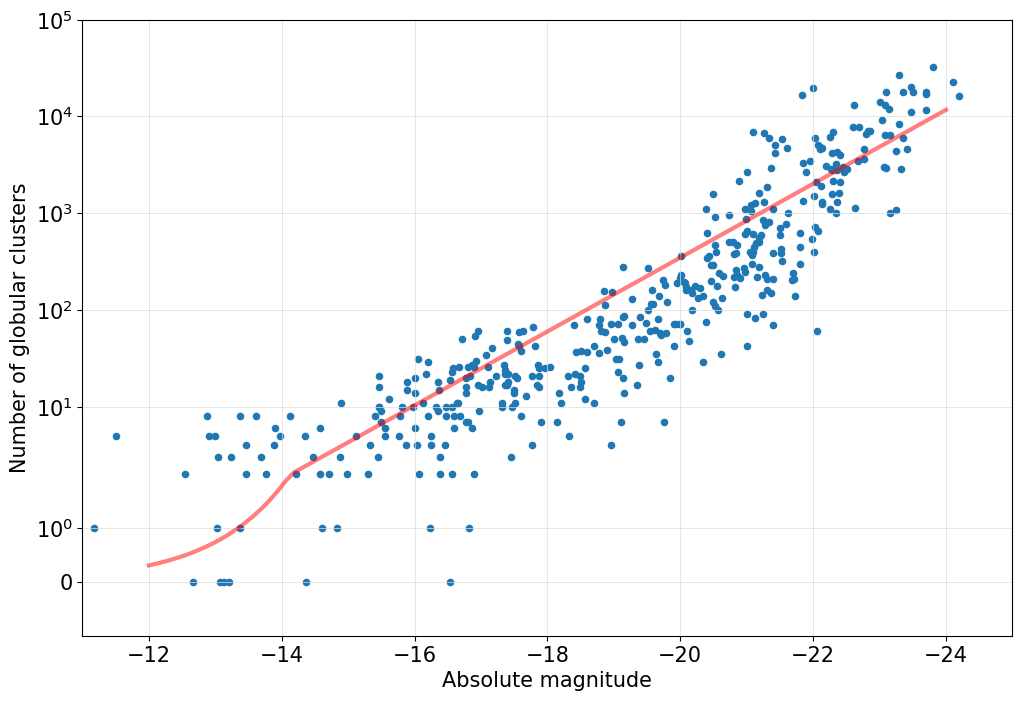

In [84]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(data['MV_T'], data['N_GC'], s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## A zero-truncated Poisson model with PyMC

Create an artificial dataset:

In [85]:
y = sp.stats.poisson.rvs(mu=2.5, size=200)
y = y + 1                                                     # No zeros in our dataset (average is now around 3.5 rather than 2.5)

To model count data that have no zero counts among them, we can use a truncated Poisson model:

In [86]:
with pm.Model() as myModel:
    
    yobs = pm.ConstantData("yobs", y)                                                                          # The observations

    mu = pm.HalfNormal("mu", sigma=4)                                                                          # The prior on the average number of counts
    truncatedPoisson = pm.Truncated("truncated_poisson", pm.Poisson.dist(mu=mu), lower=1, observed=yobs)       # Truncate the counts to be >= 1.

    trace = pm.sample(3000, chains=4, cores=2, return_inferencedata=True, random_seed=341592)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu]


/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/step_methods/hmc/integration.py:124: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp
/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/step_methods/hmc/integration.py:124: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp
/Users/joris/miniconda3/envs/course/lib/python3.11/site-packages/pymc/step_methods/hmc/integration.py:124: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


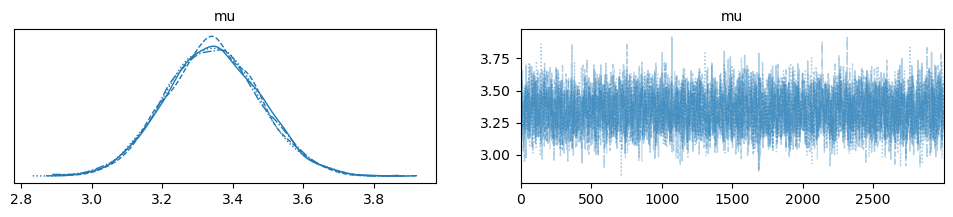

In [87]:
ax = az.plot_trace(trace)

Back to [contents](#Contents).

---